In [1]:
# this jupiter notebook is for using opensoundscape to visualize spectrograms from training data or original annotations 

In [1]:
import opensoundscape
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import librosa
import torch
import random
import sys
from PIL import Image as im 
import cv2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load datasets
CC_2004_07 = pd.read_csv('/Users/samuelguimte/Documents/PSTAT 197/modified_annotations/MasterSheet_modification.csv')


In [3]:
# """ # plot spectrograms from each deployment
# # CalCOFI-2004-07
# for index, row in CC_2004_07.iterrows():

#     audio_file_name = os.path.split(row['audio_file'])[1]
#     audio = opensoundscape.Audio.from_file(row['audio_file'], sample_rate=48000, offset=row['start_time'], duration=6)

#     if audio.samples.shape[0] > 0:  # Assuming audio.samples returns a numpy array of audio samples
#         # create spectrogram:
#         spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
#                                                      overlap_samples=21600, fft_size=48000, 
#                                                      scaling='density')
        
#         # convert spectrogram to image:
#         spec_image = spec.bandpass(0, 200).to_image()

#     #spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
#                                                                 #overlap_samples=21600, fft_size=48000, 
#                                                                 #decibel_limits=(-100, 100), scaling='density')
#     else:
#         print(f"No audio samples found for file: {row['audio_file']}")

#     #spec_image = spec.bandpass(0, 200).to_image()
#     #plt.figure(figsize=(12, 8))
#     #plt.imshow(spec_image)
#     plt.title(f'Audio file: {audio_file_name} Call label: {row["annotation"]} start time: {row["start_time"]} end time: {r """ow["end_time"]}')

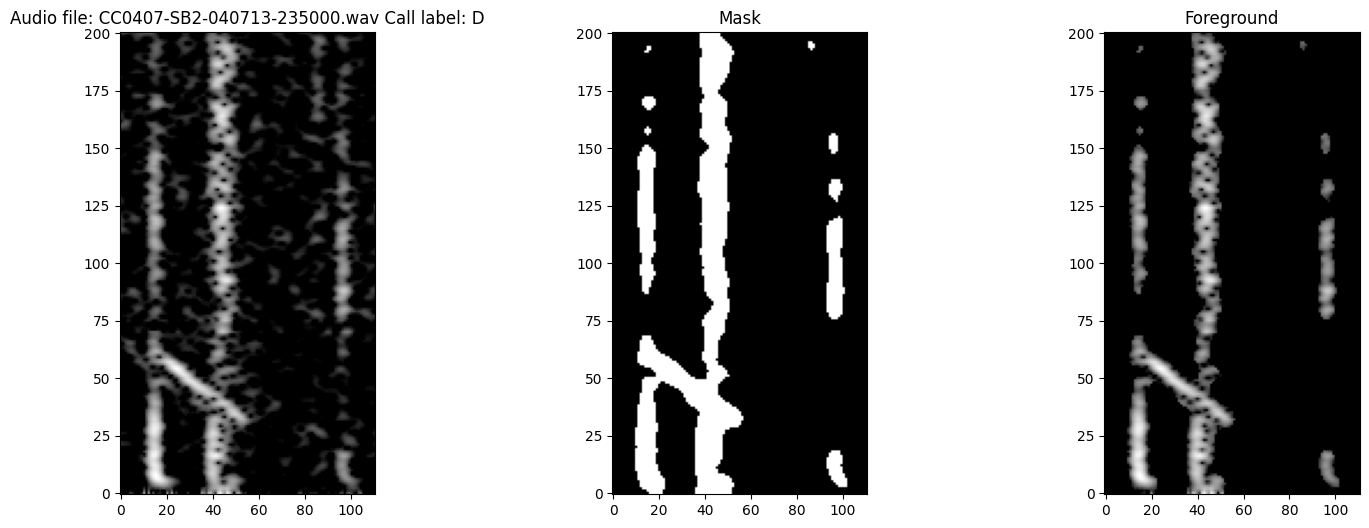

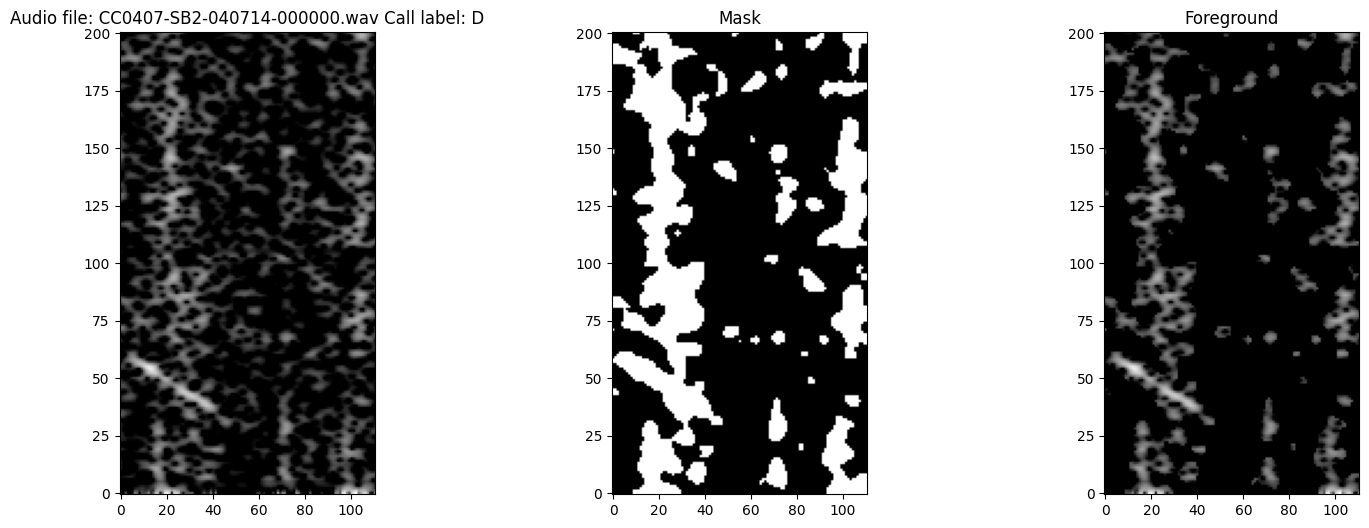

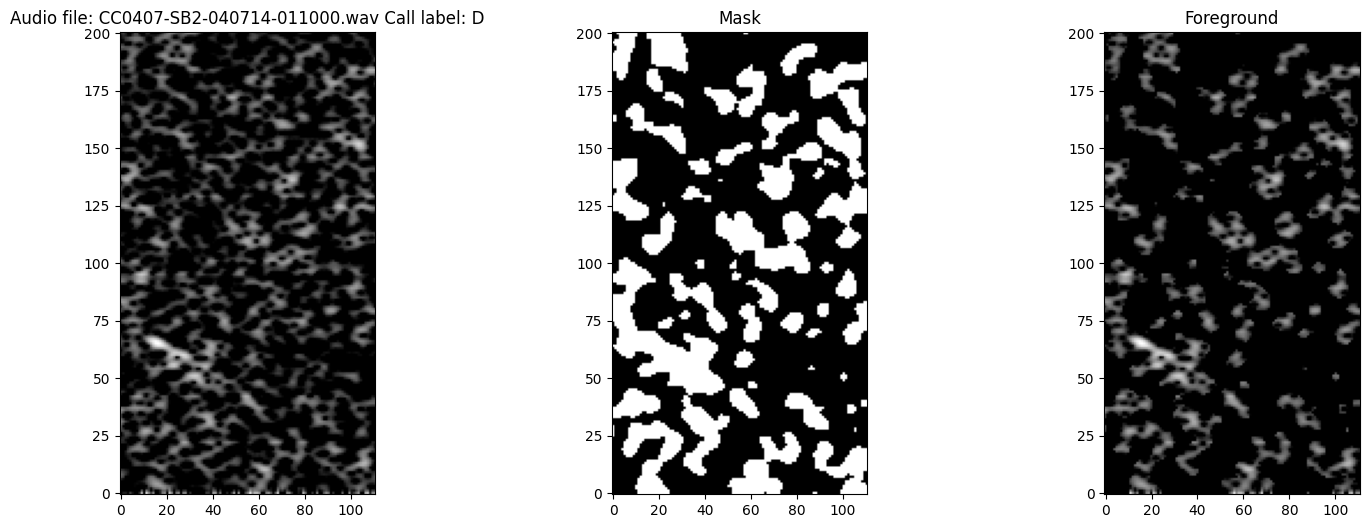

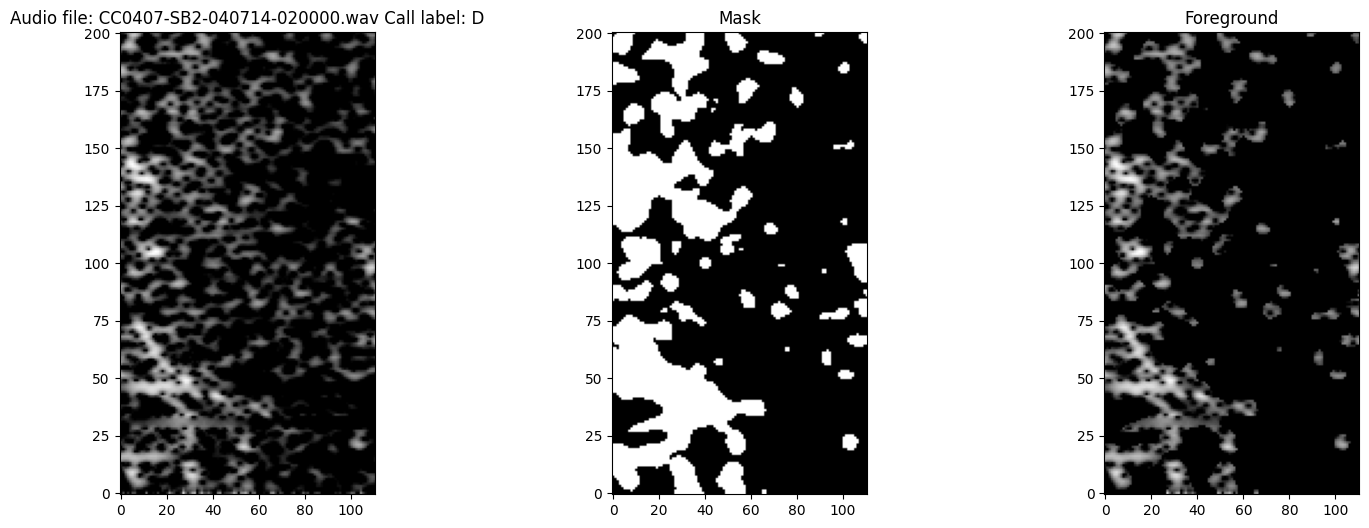

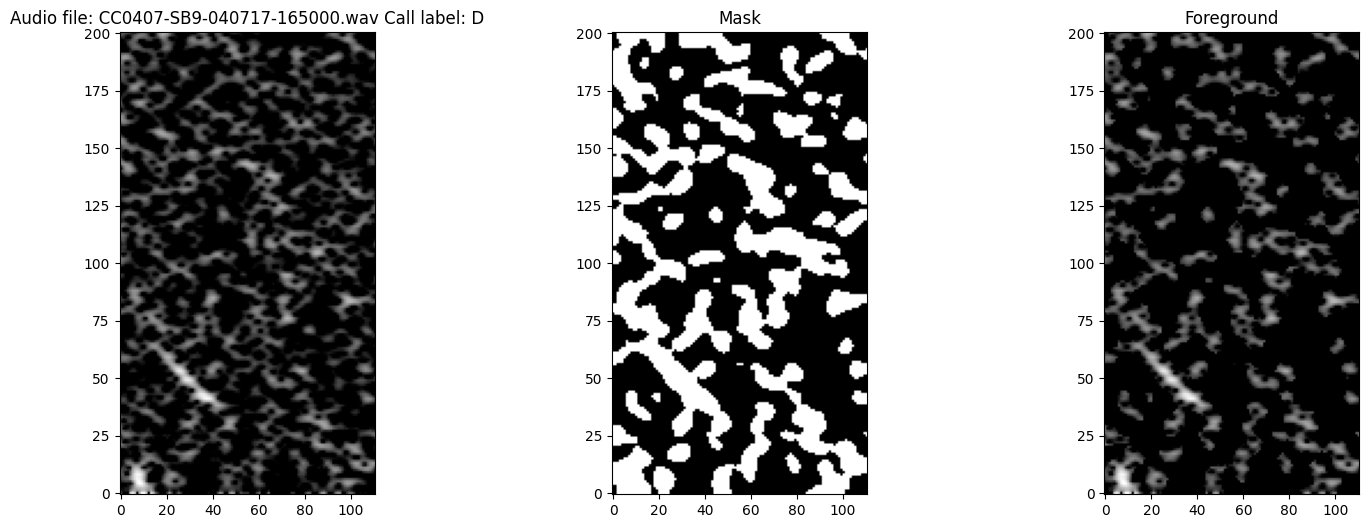

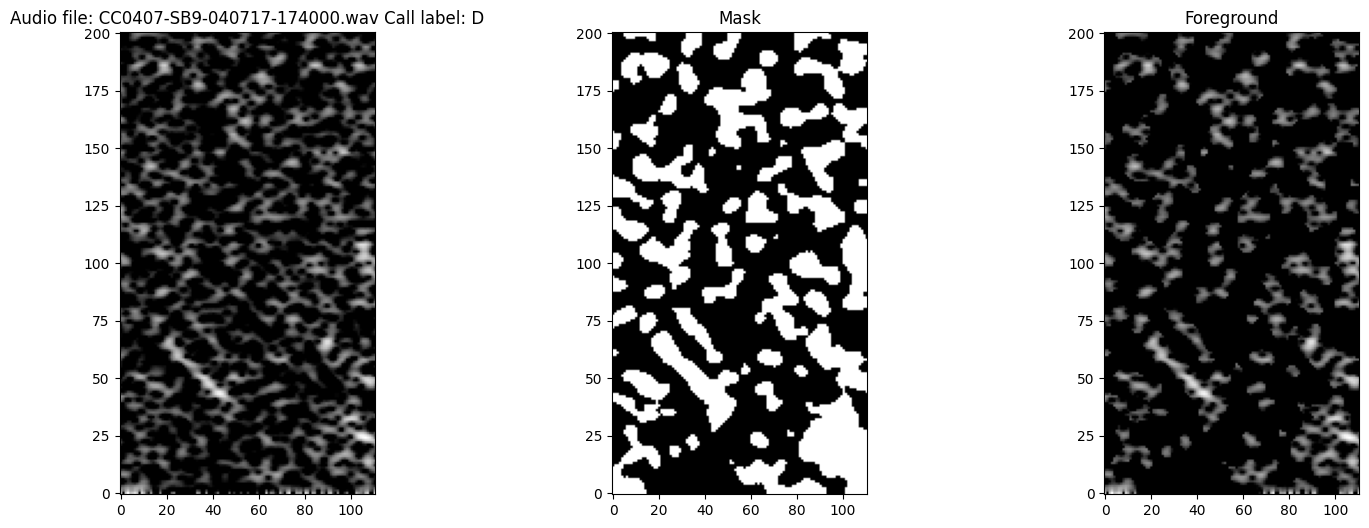

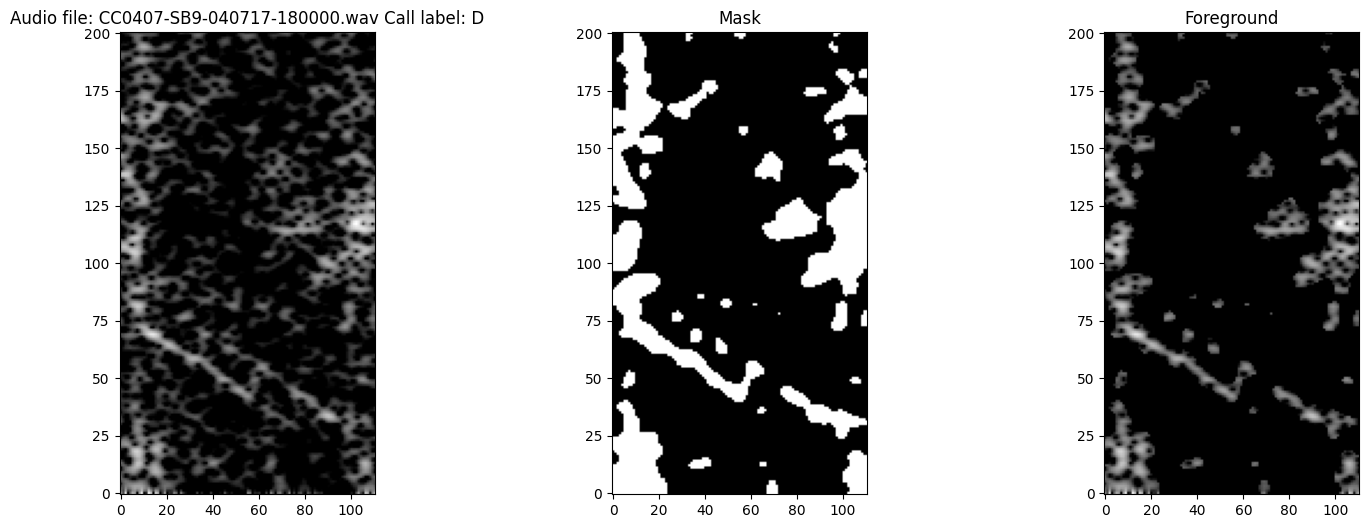

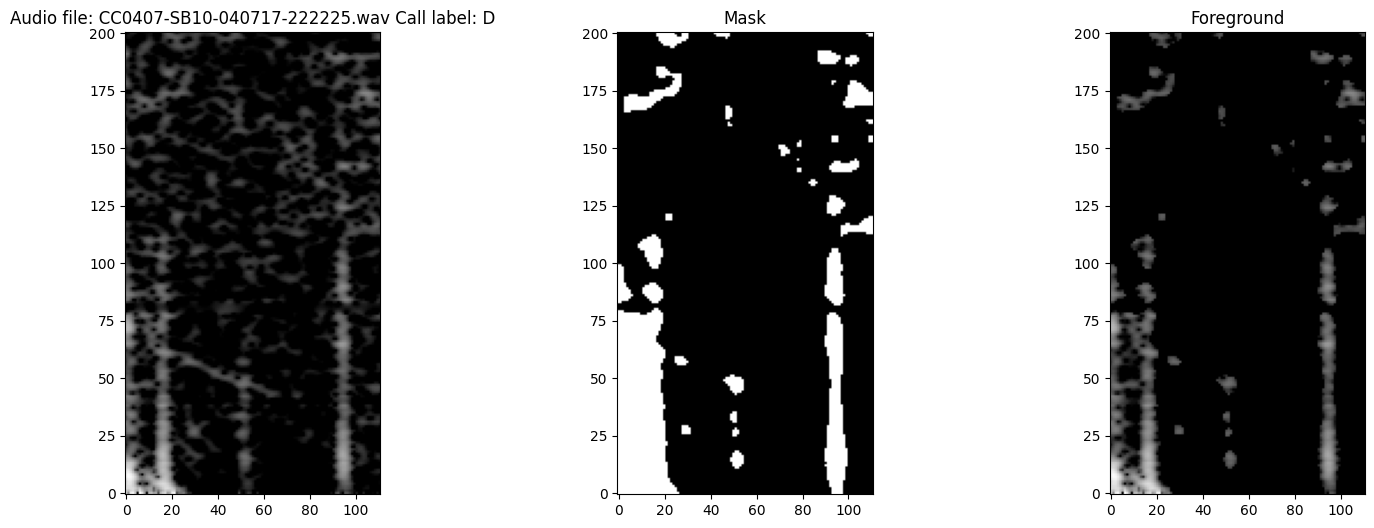

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/opensoundscape/audio.py:328: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


No audio samples found for file: /Users/samuelguimte/Documents/PSTAT 197/master_wav_sonobuoy/CC0407-SB10-040717-223000.wav


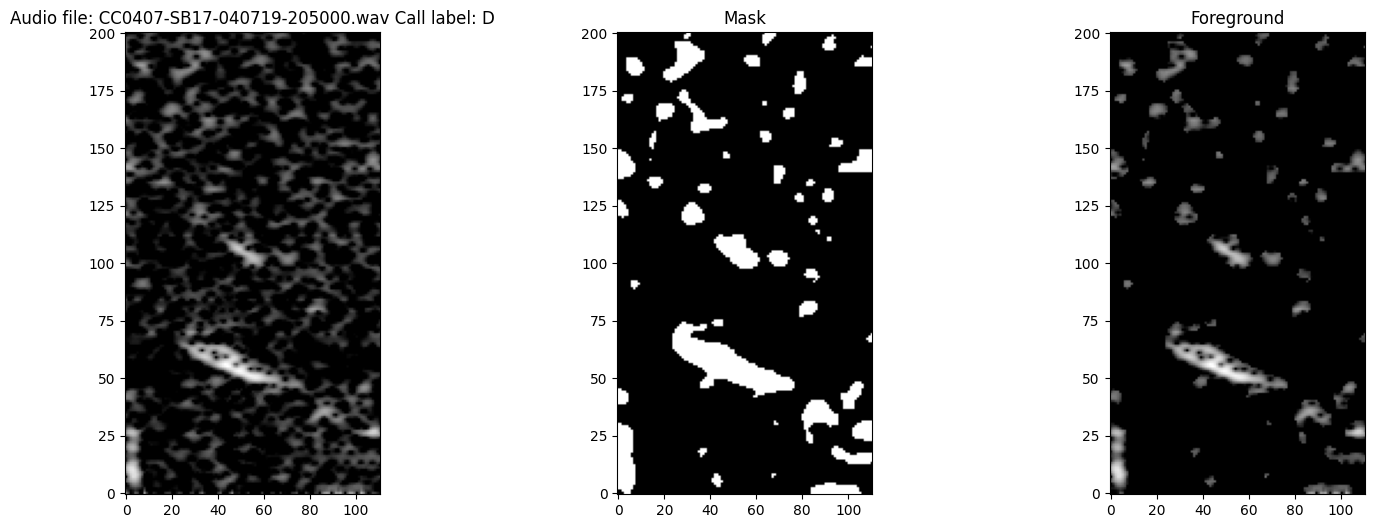

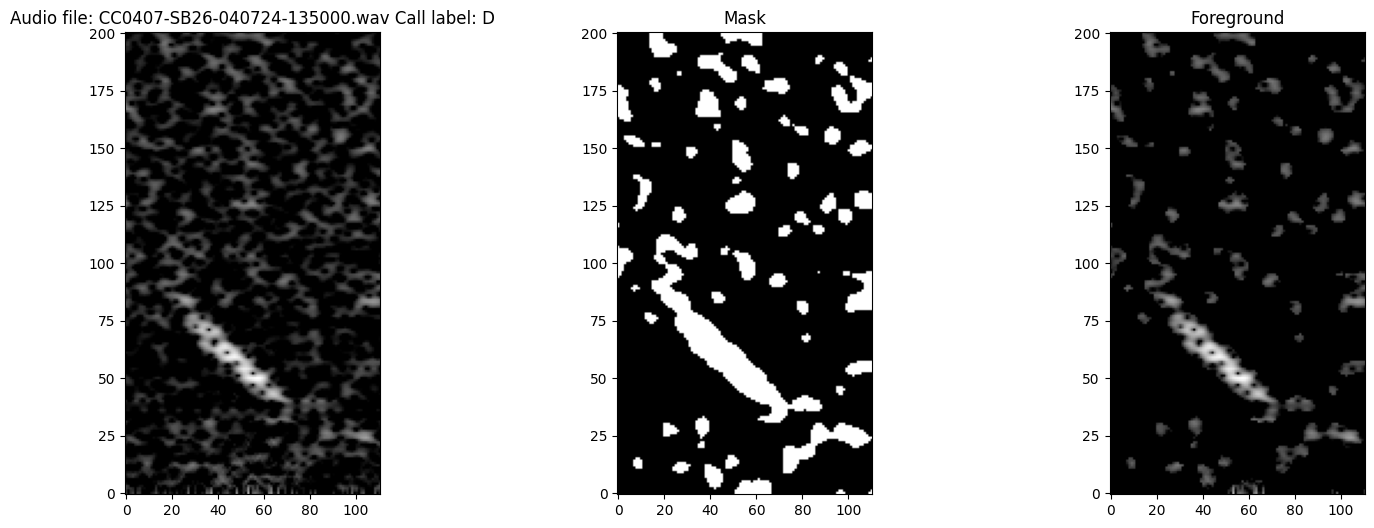

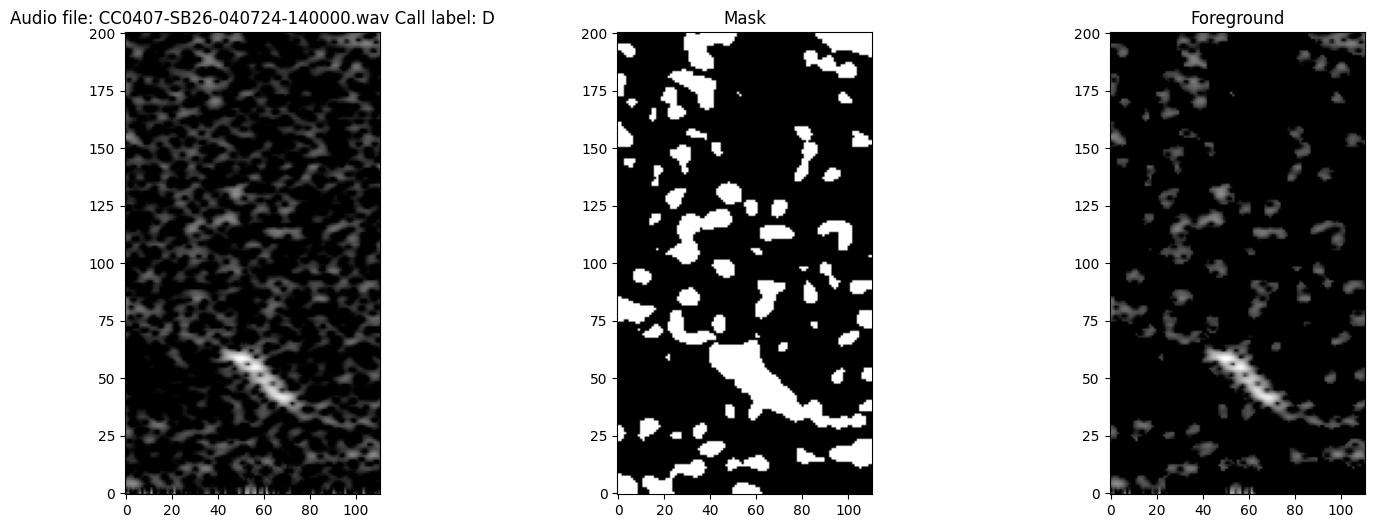

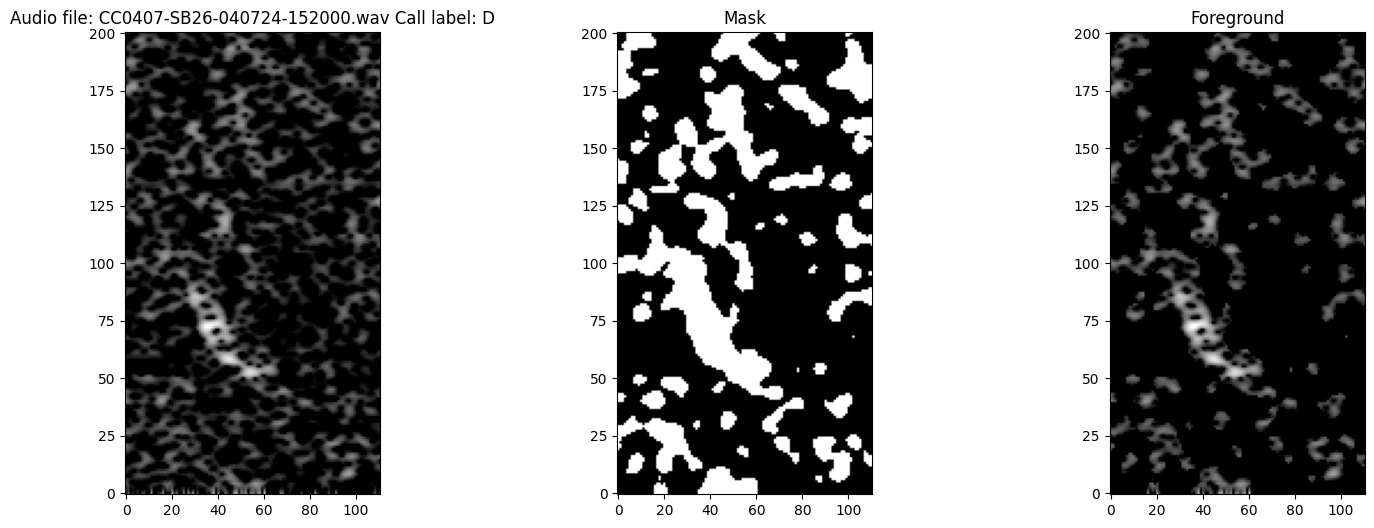

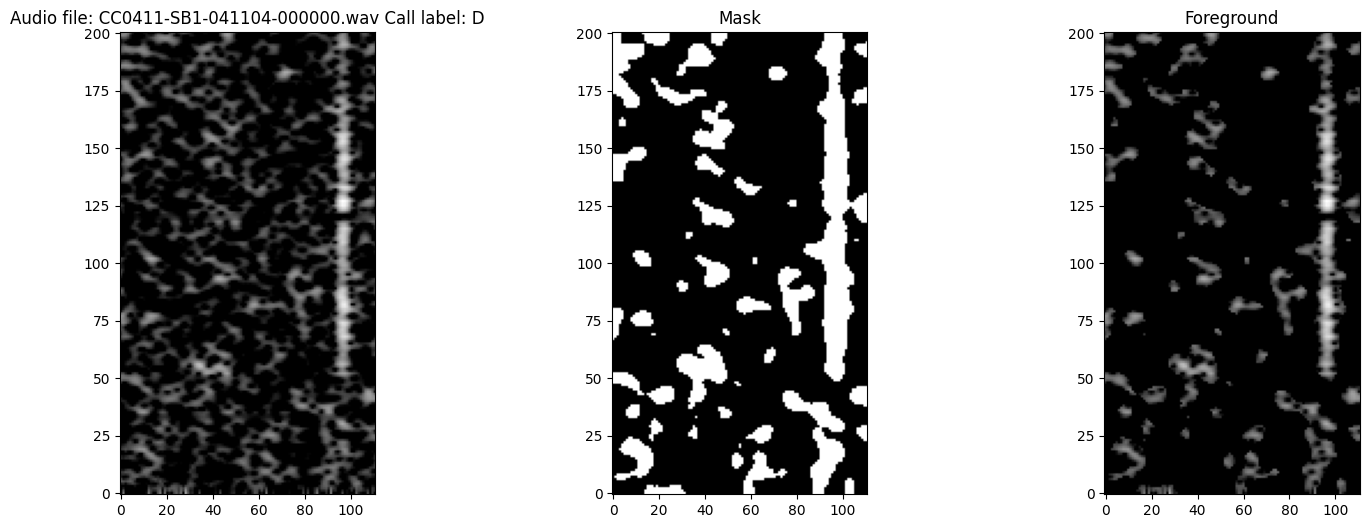

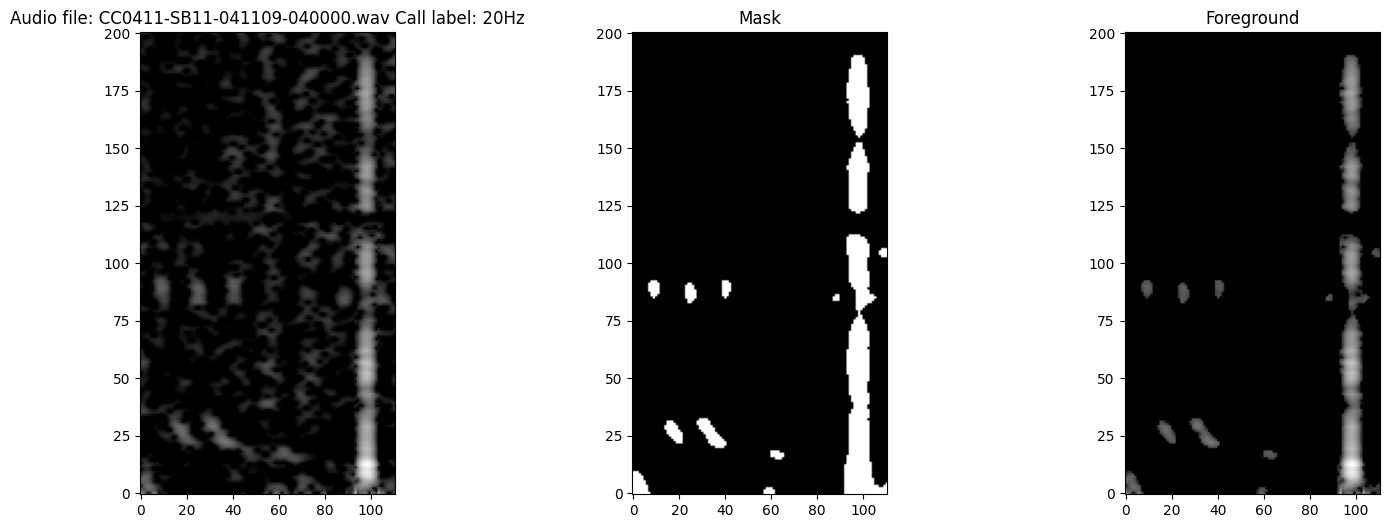

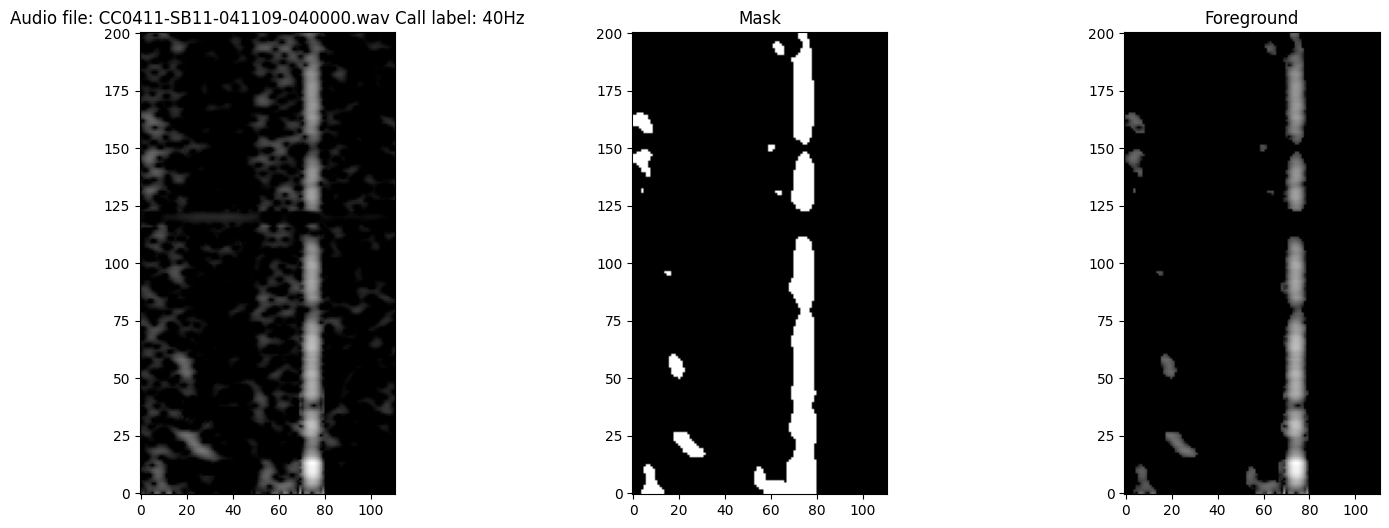

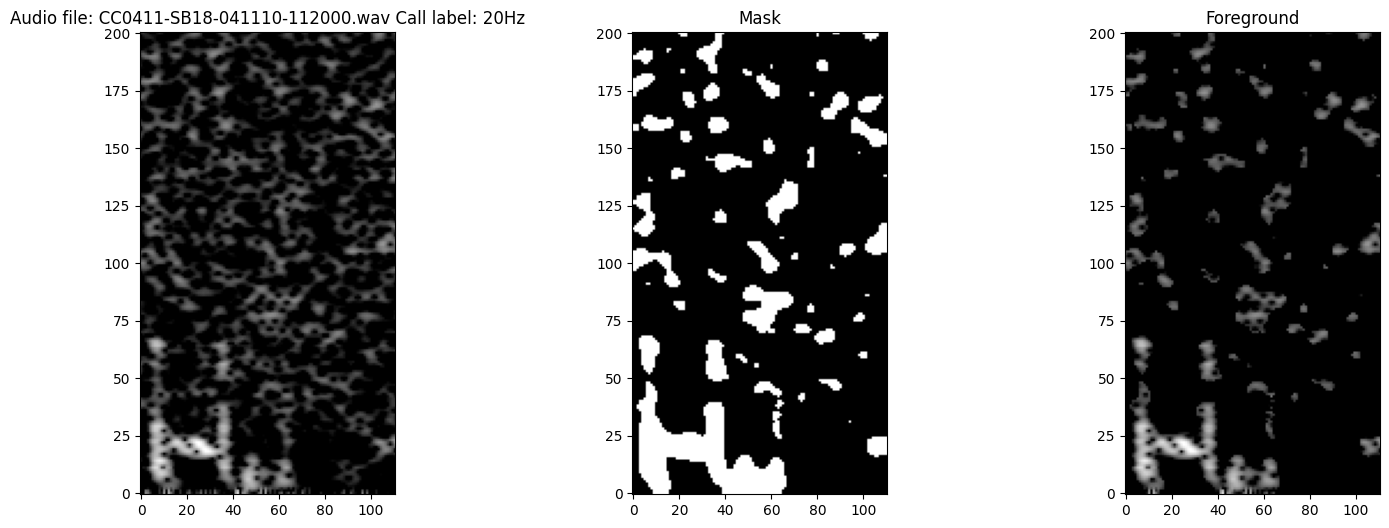

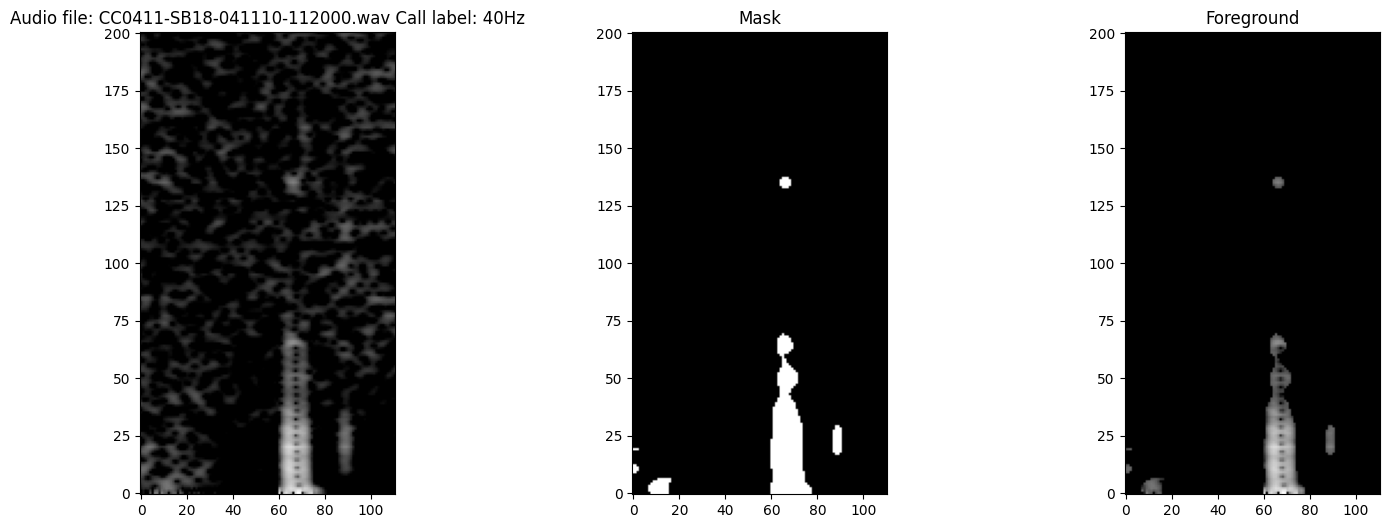

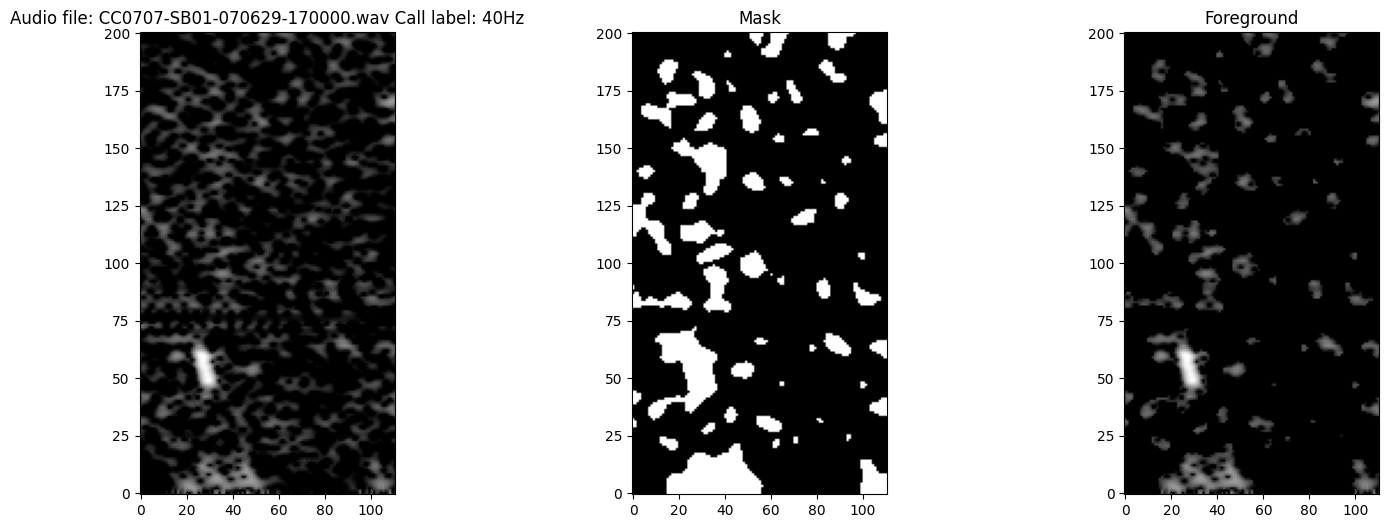

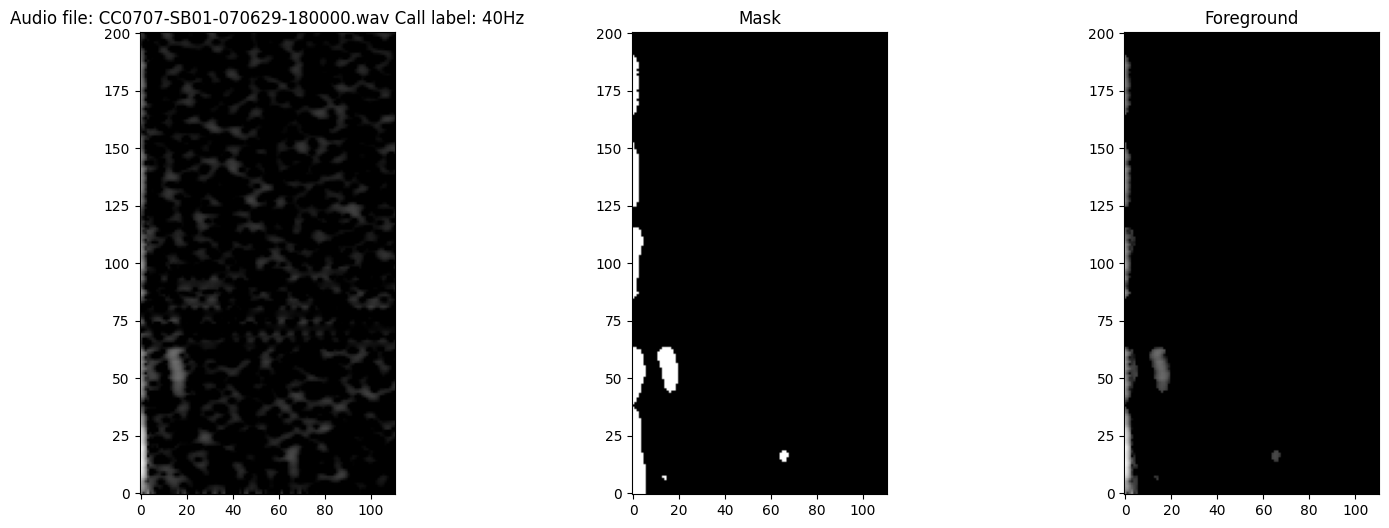

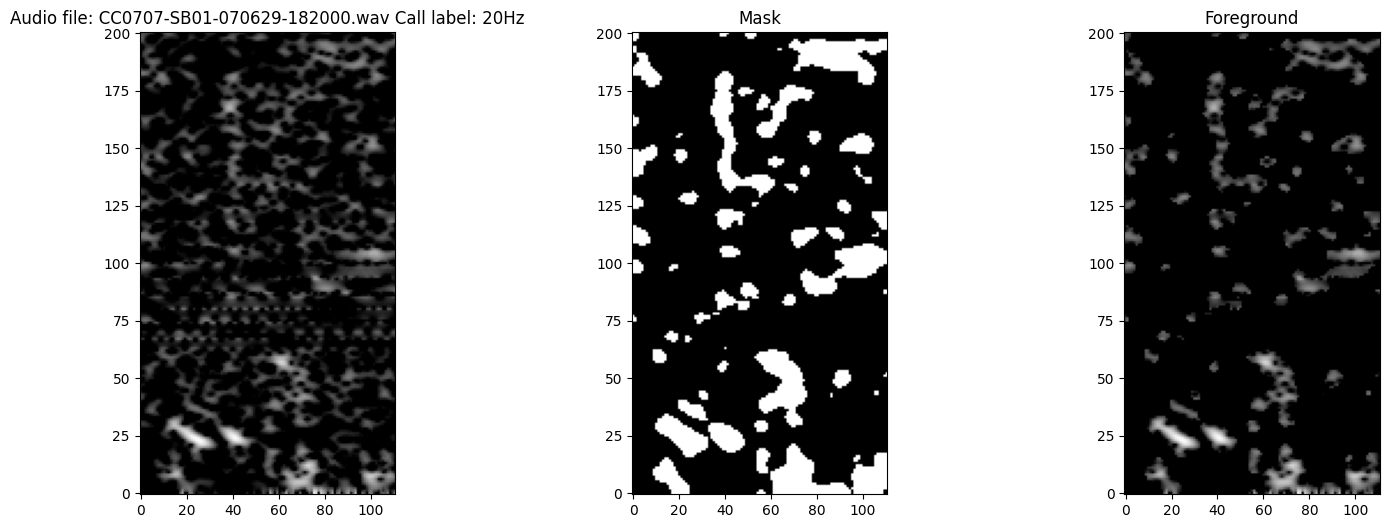

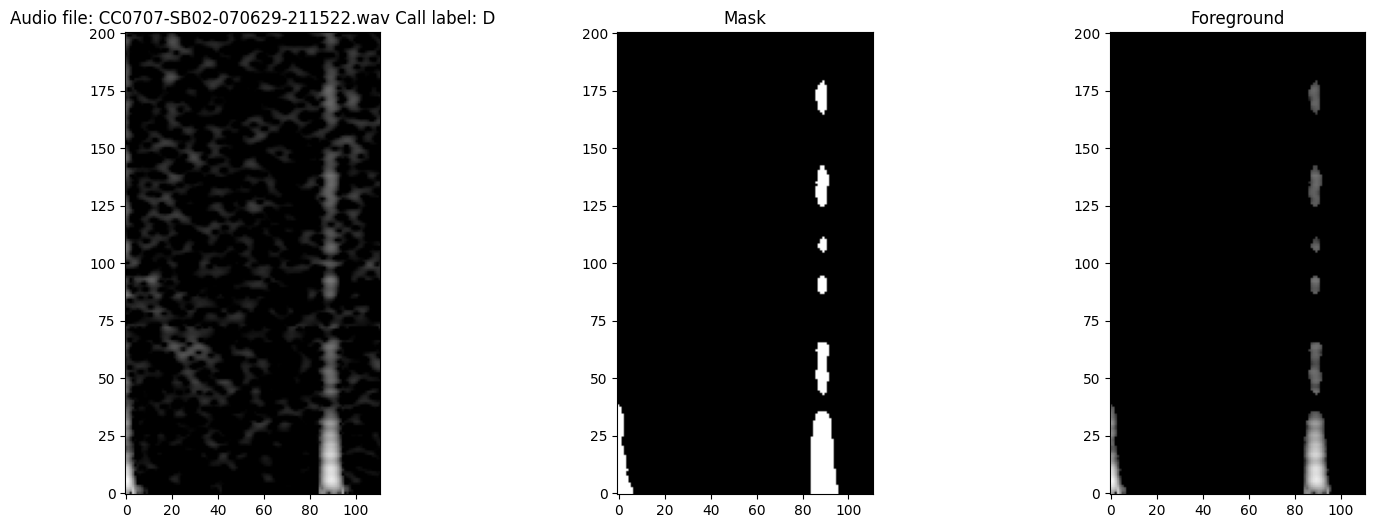

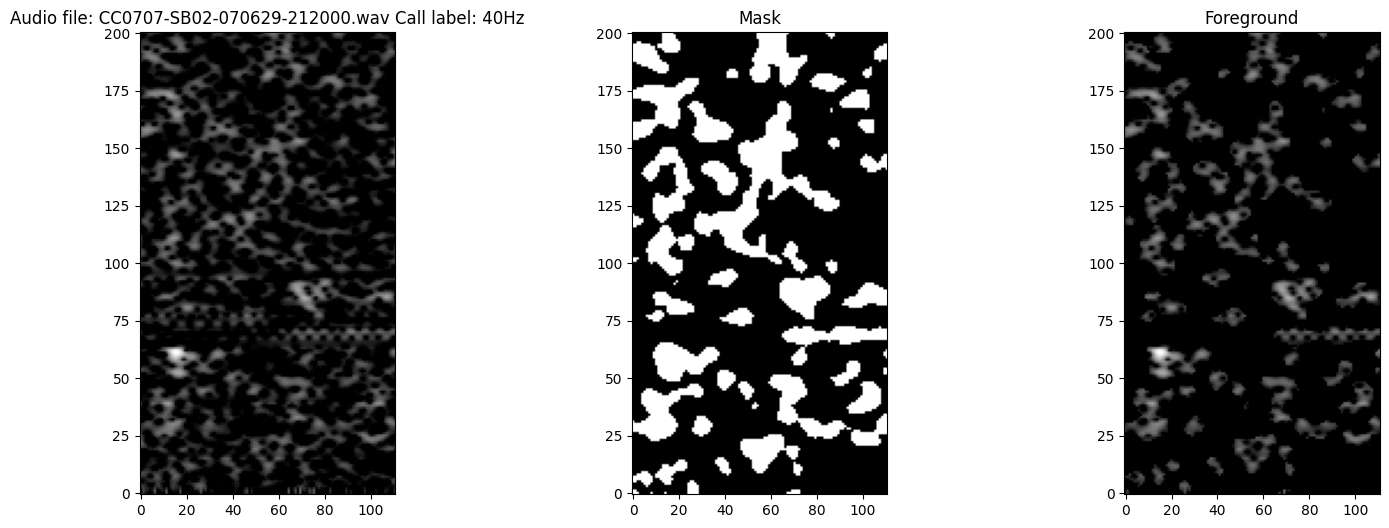

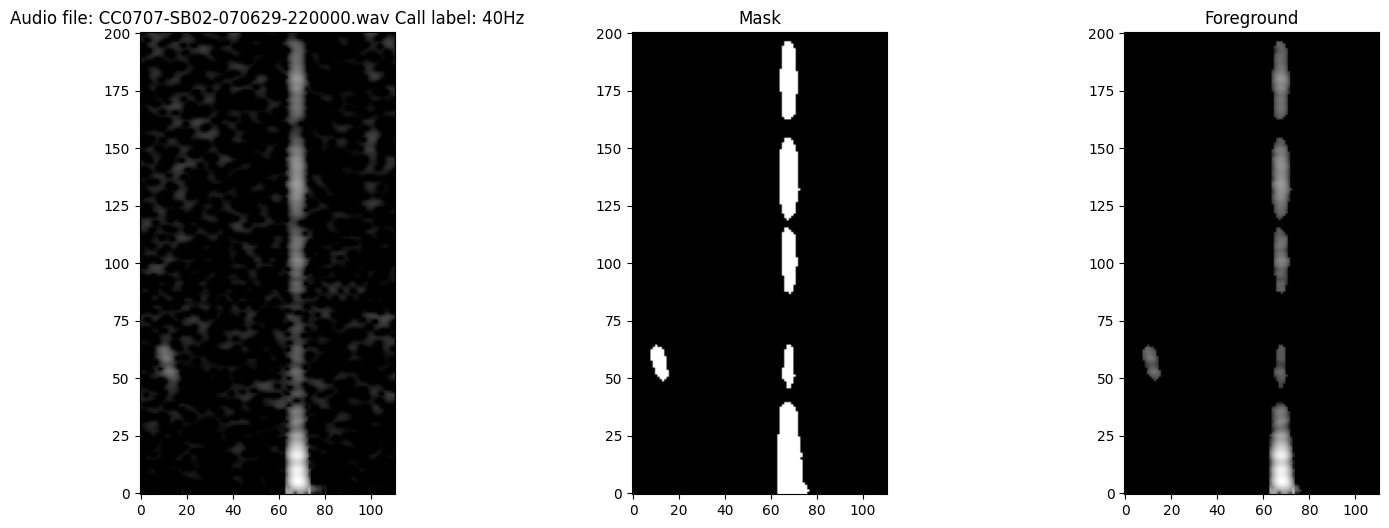

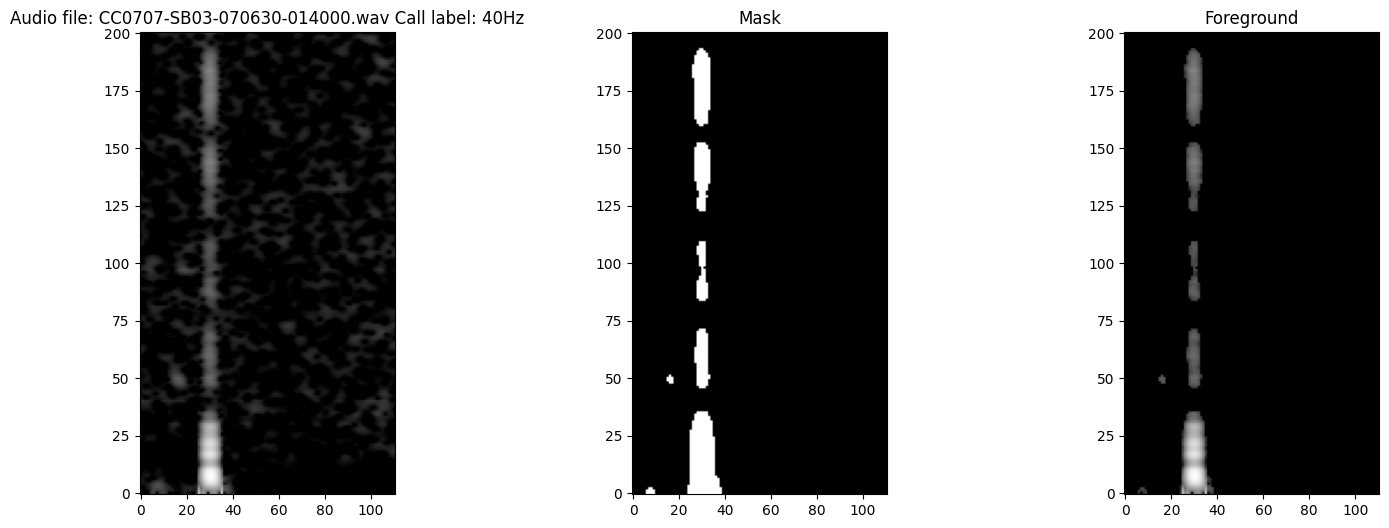

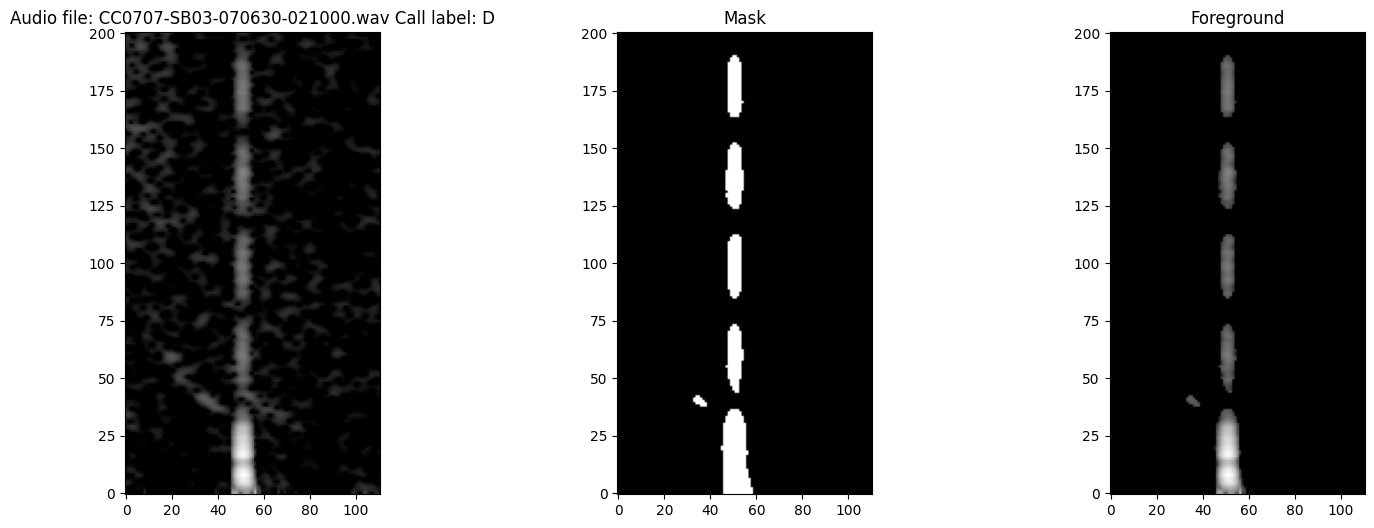

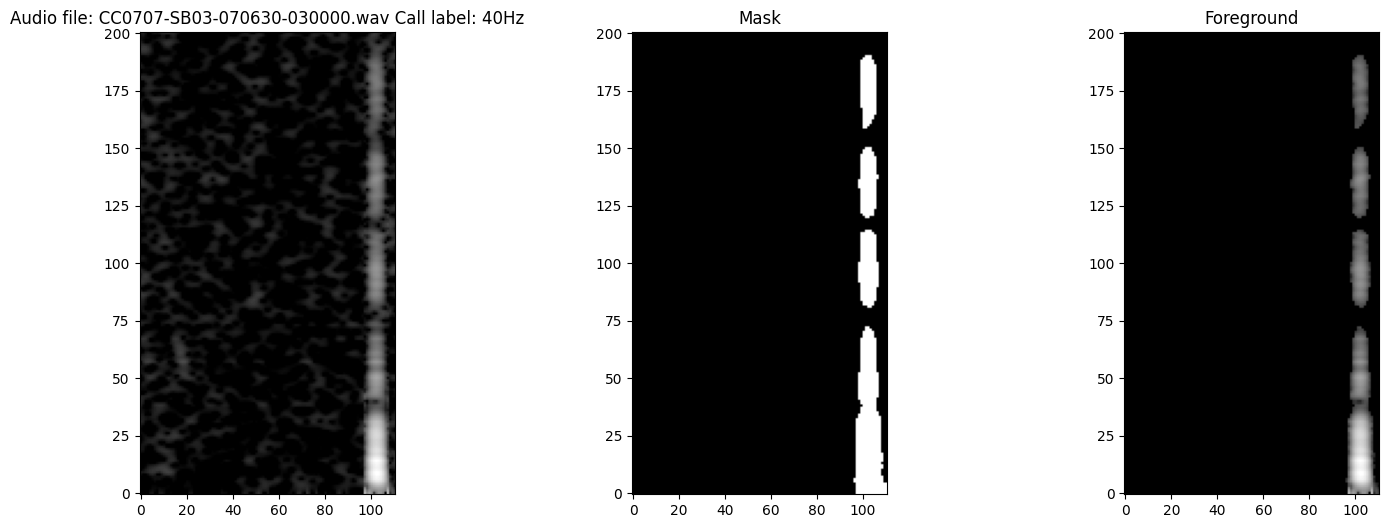

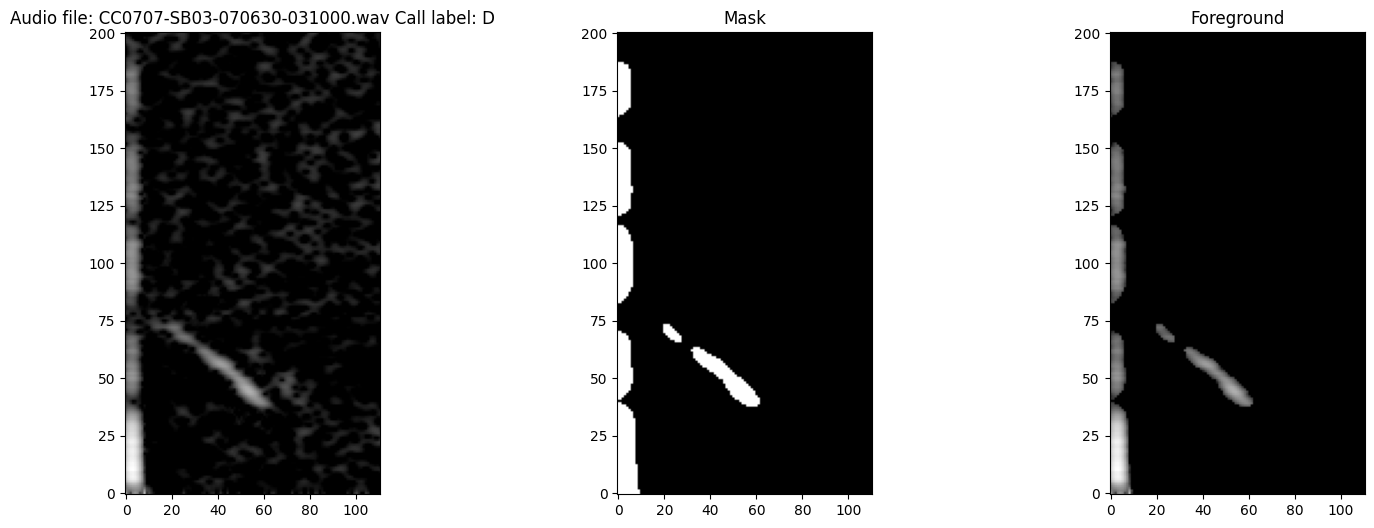

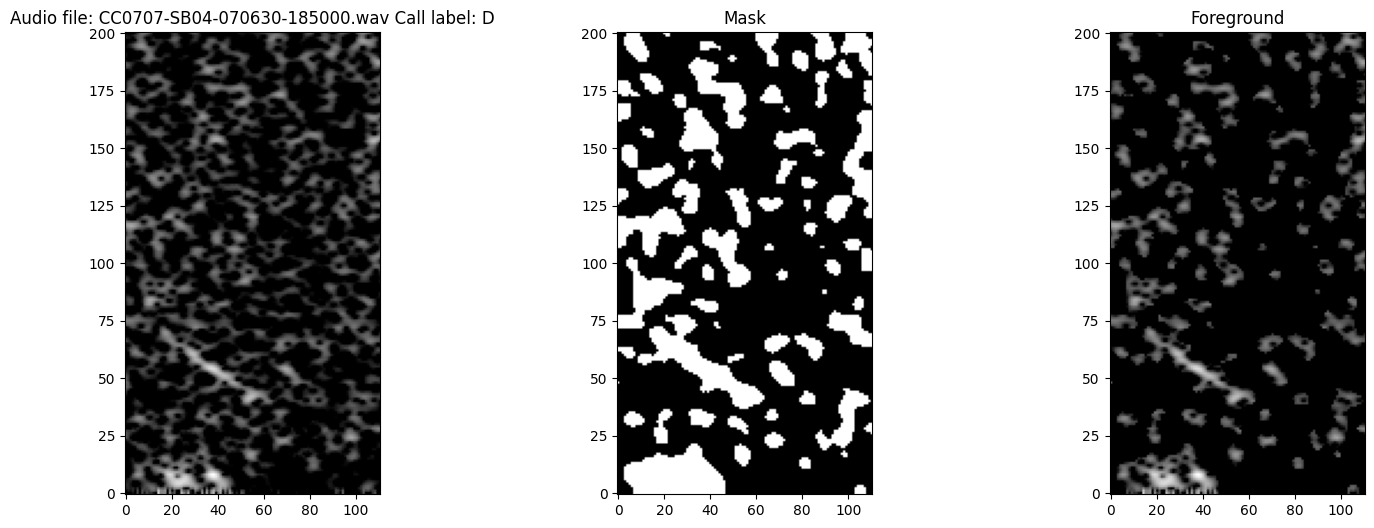

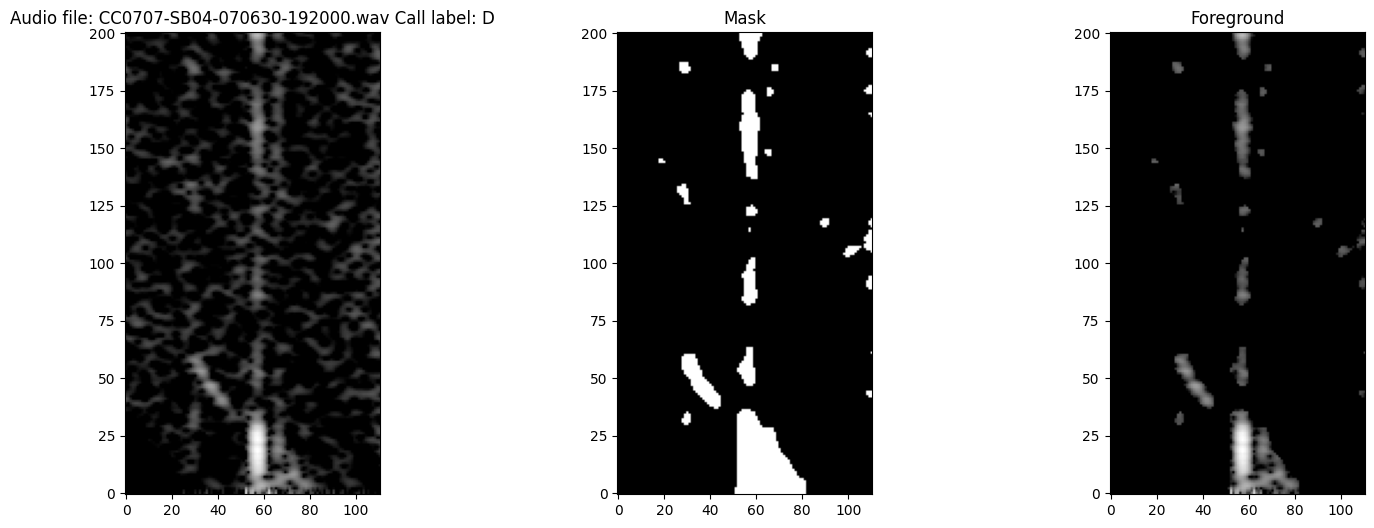

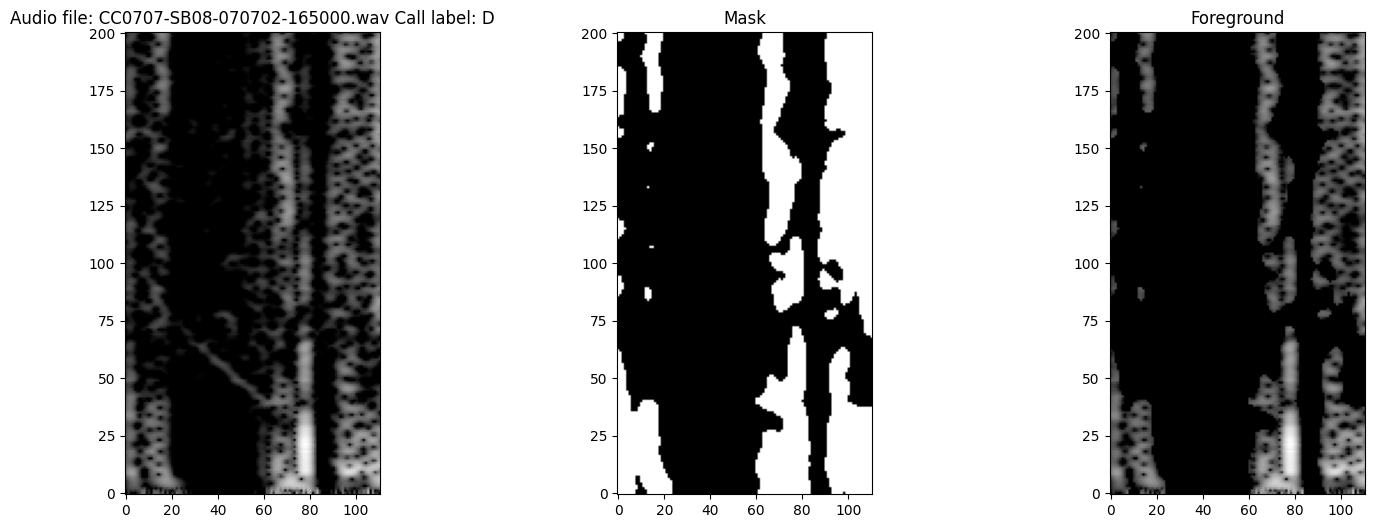

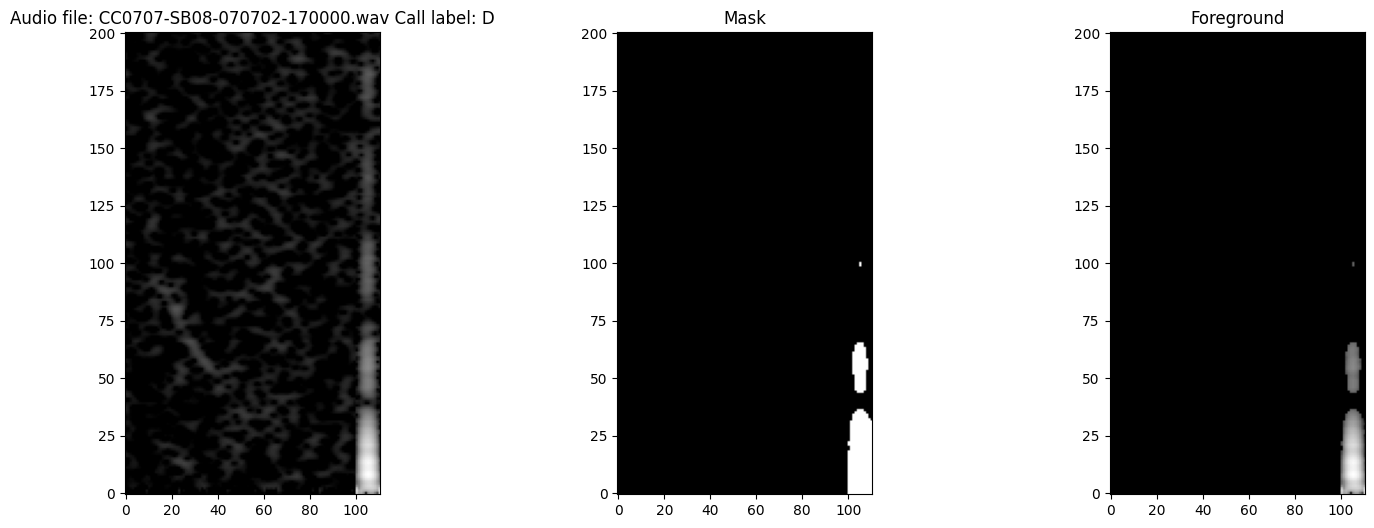

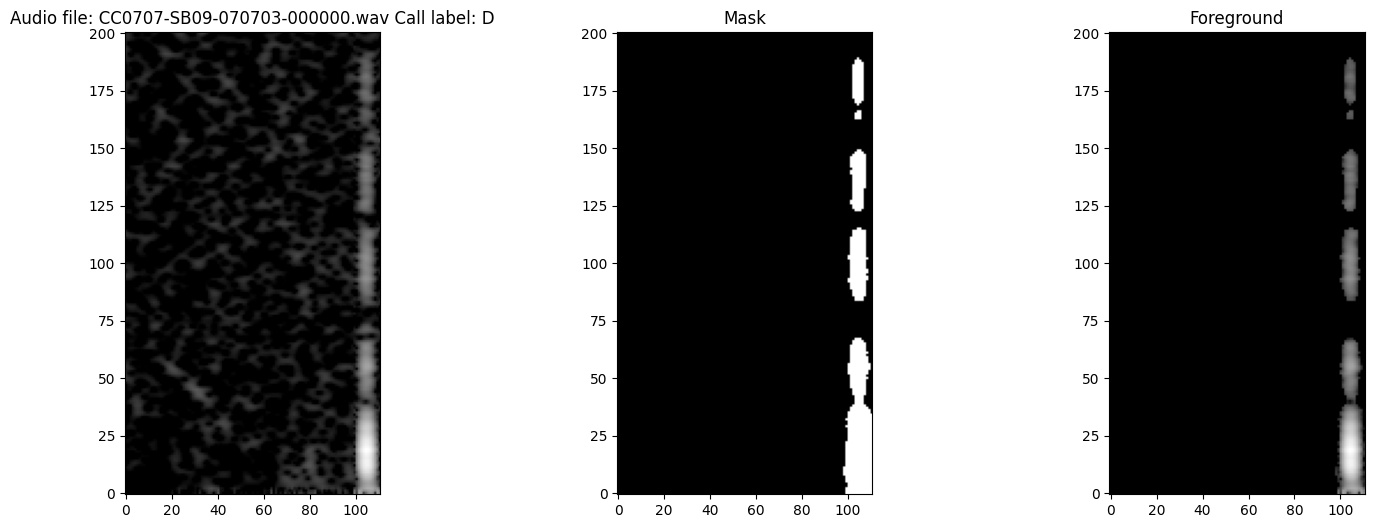

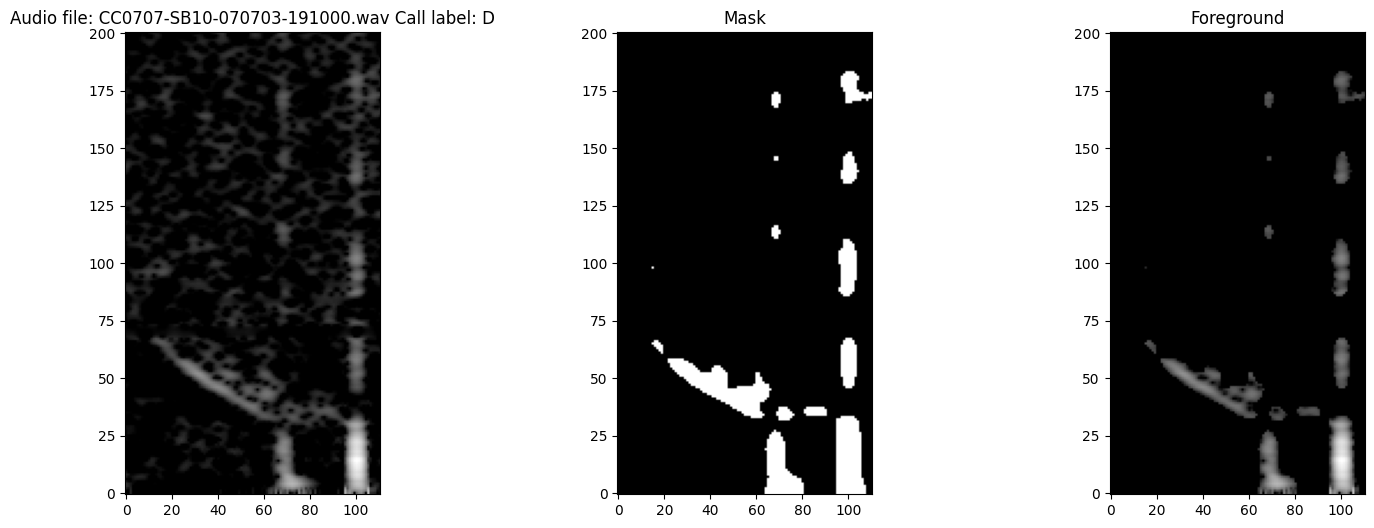

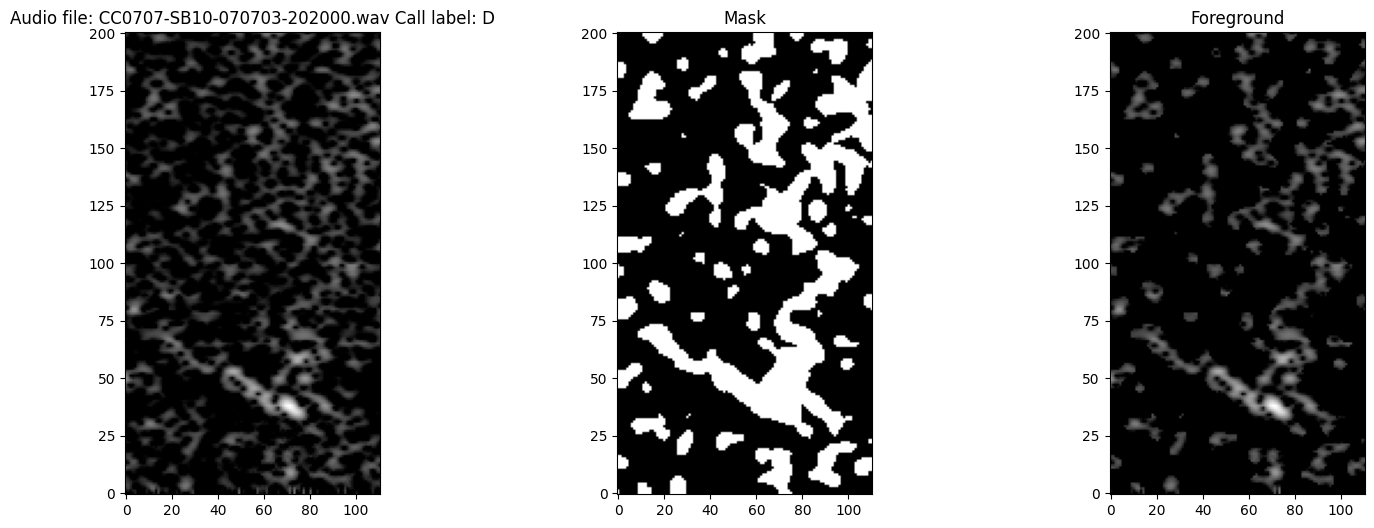

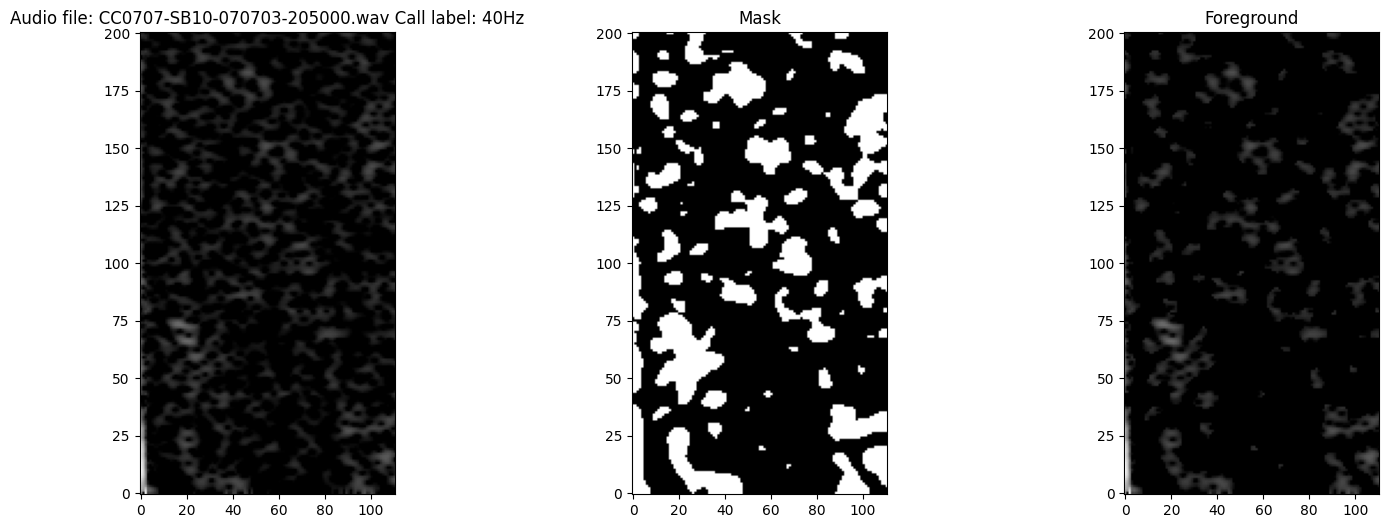

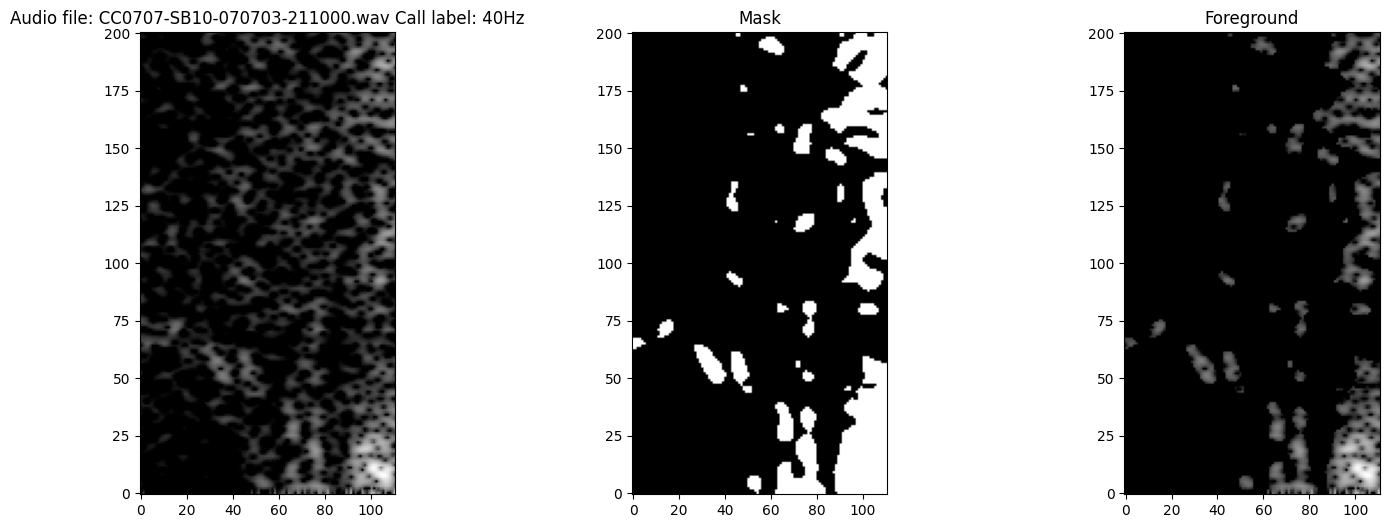

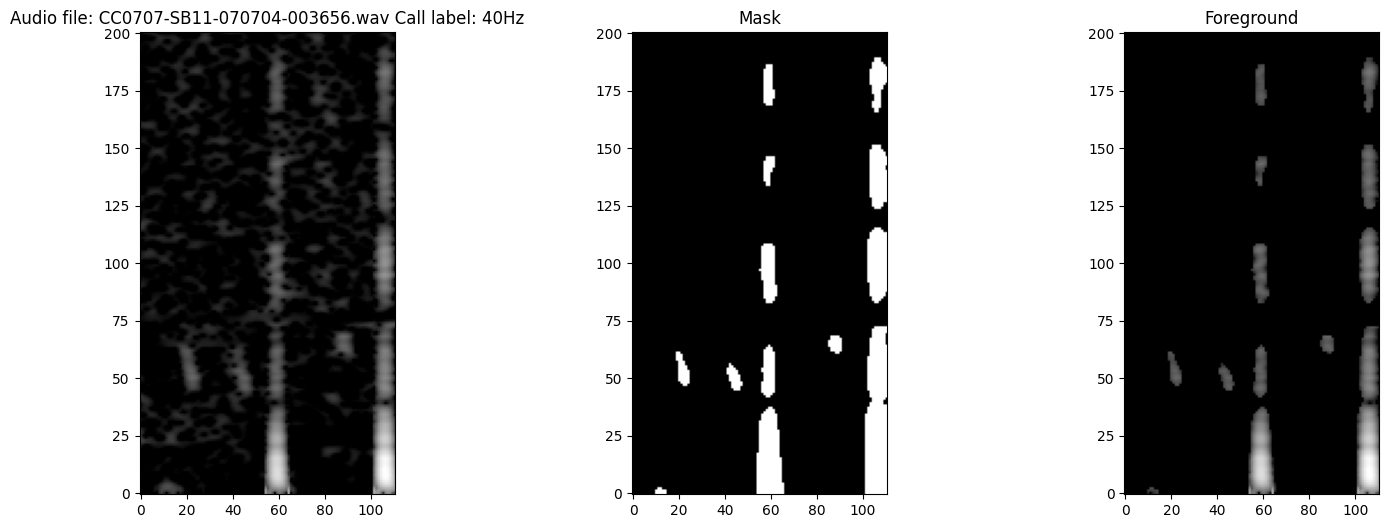

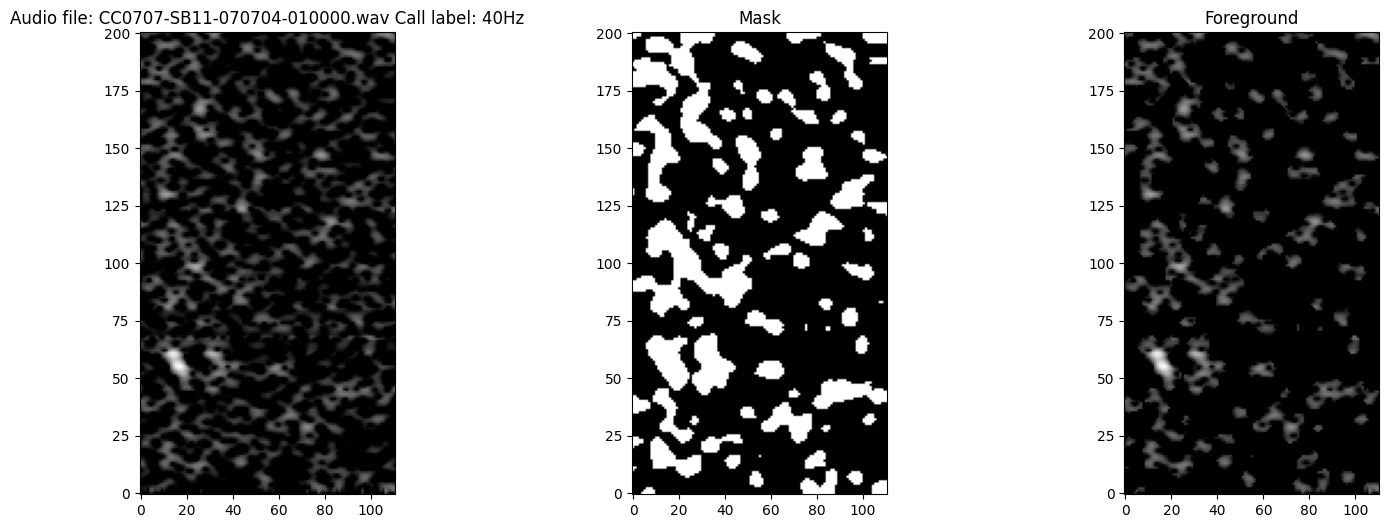

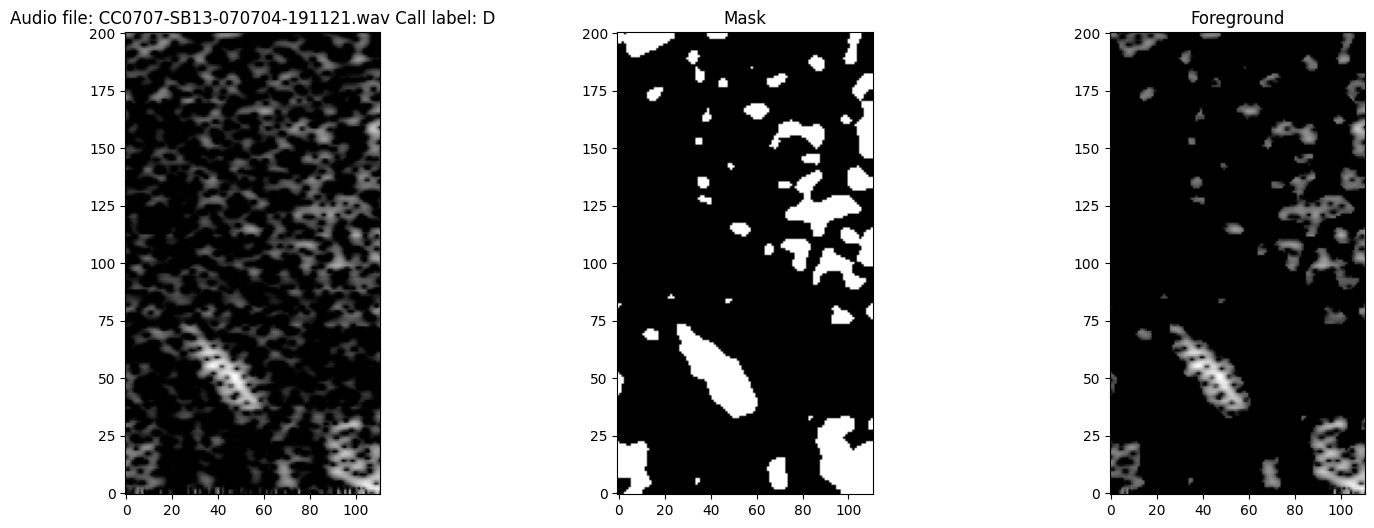

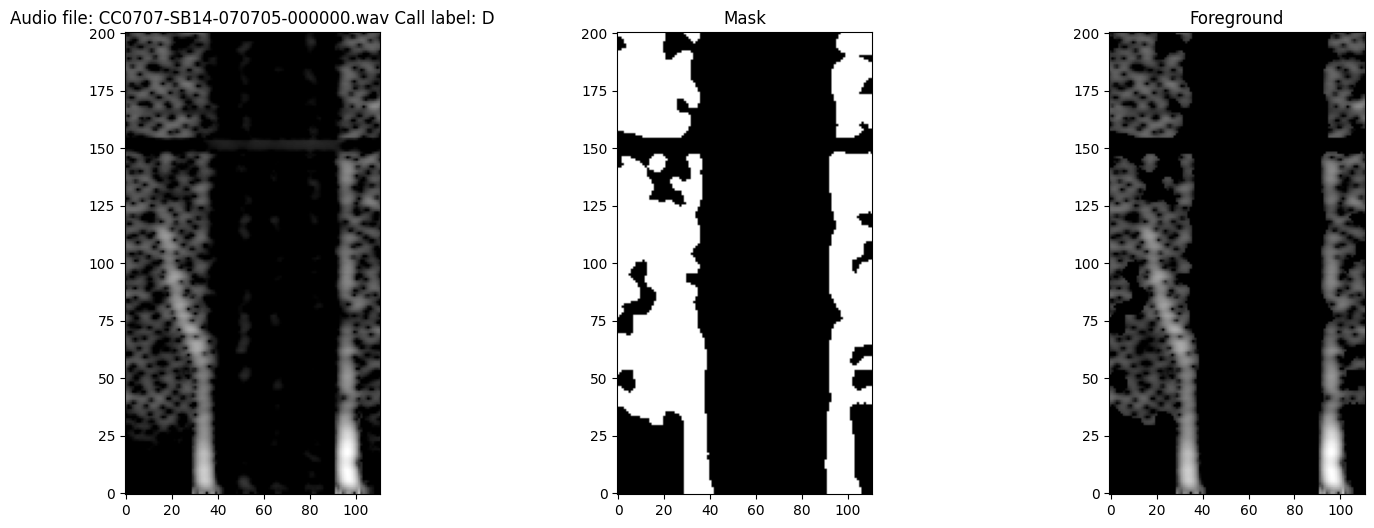

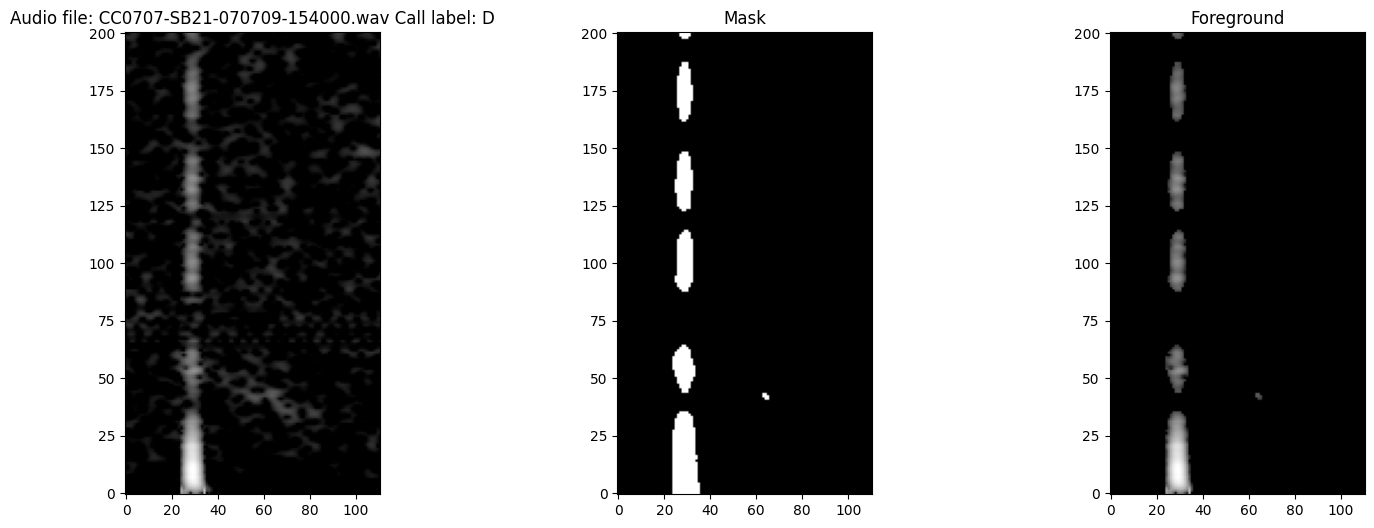

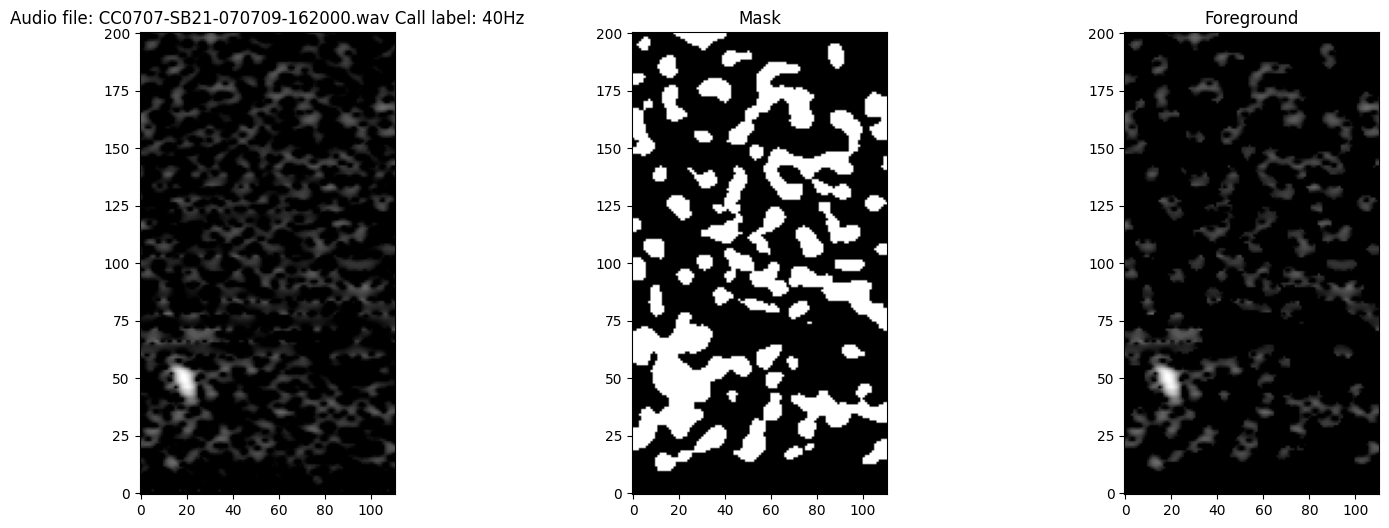

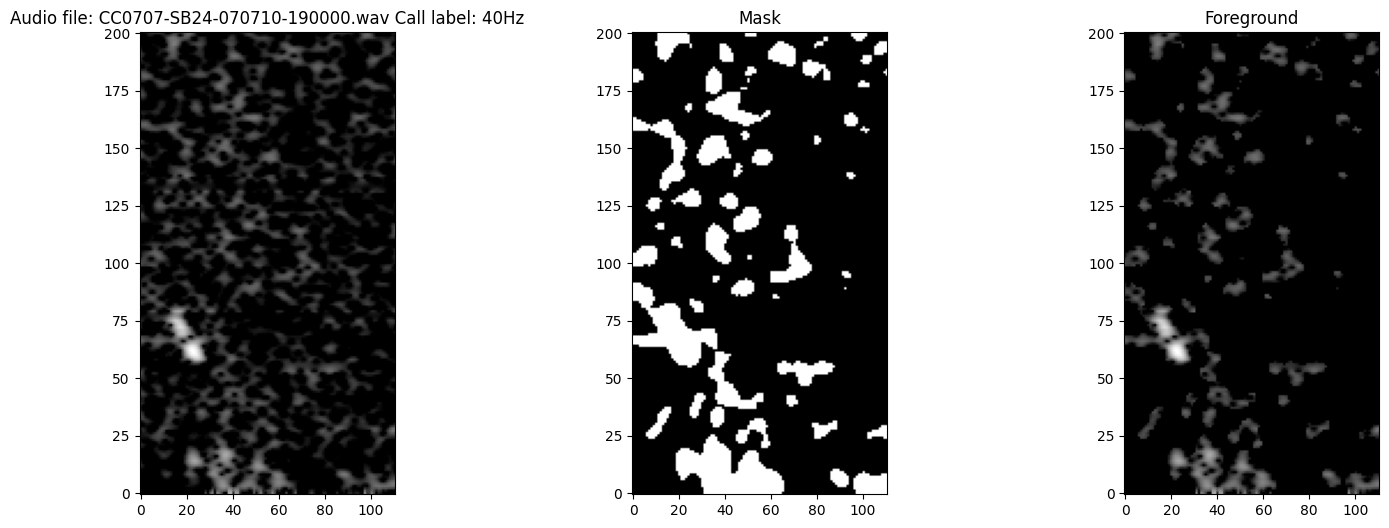

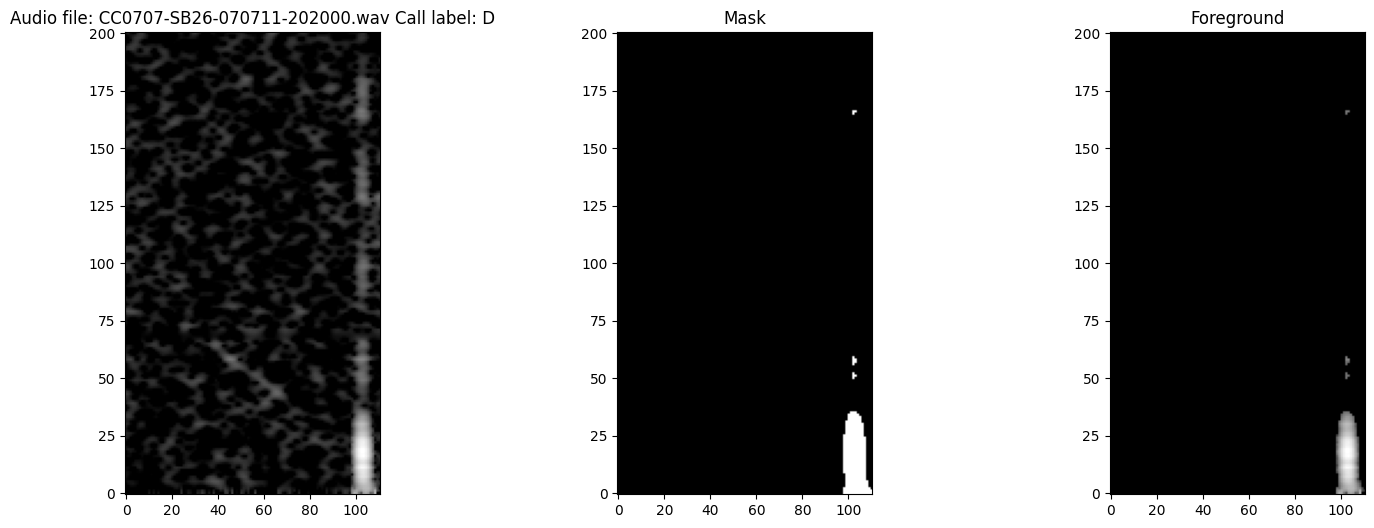

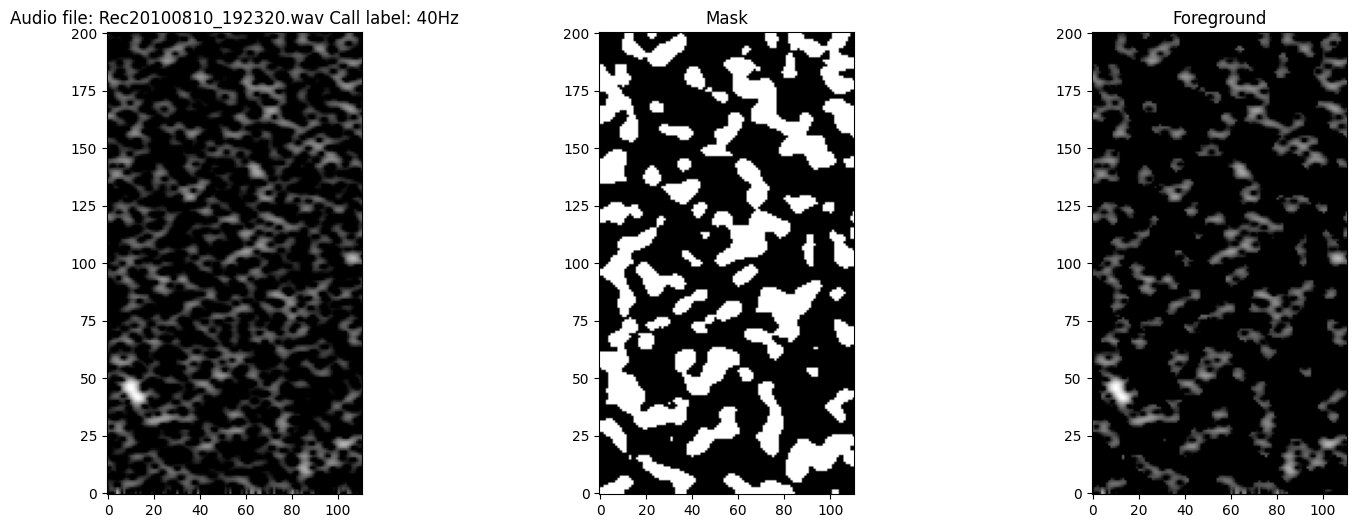

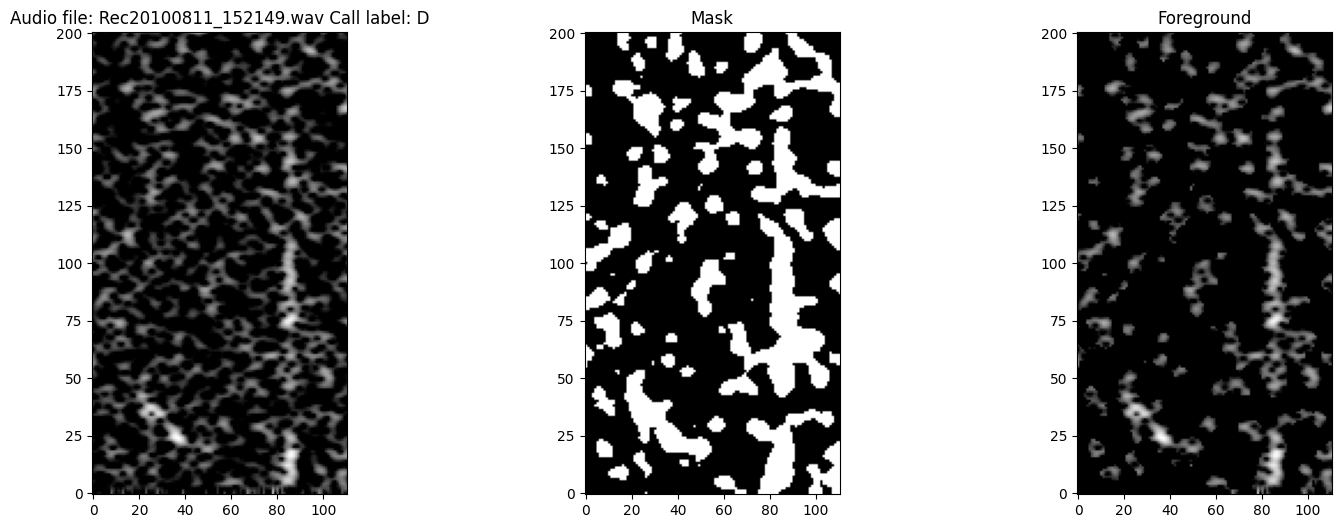

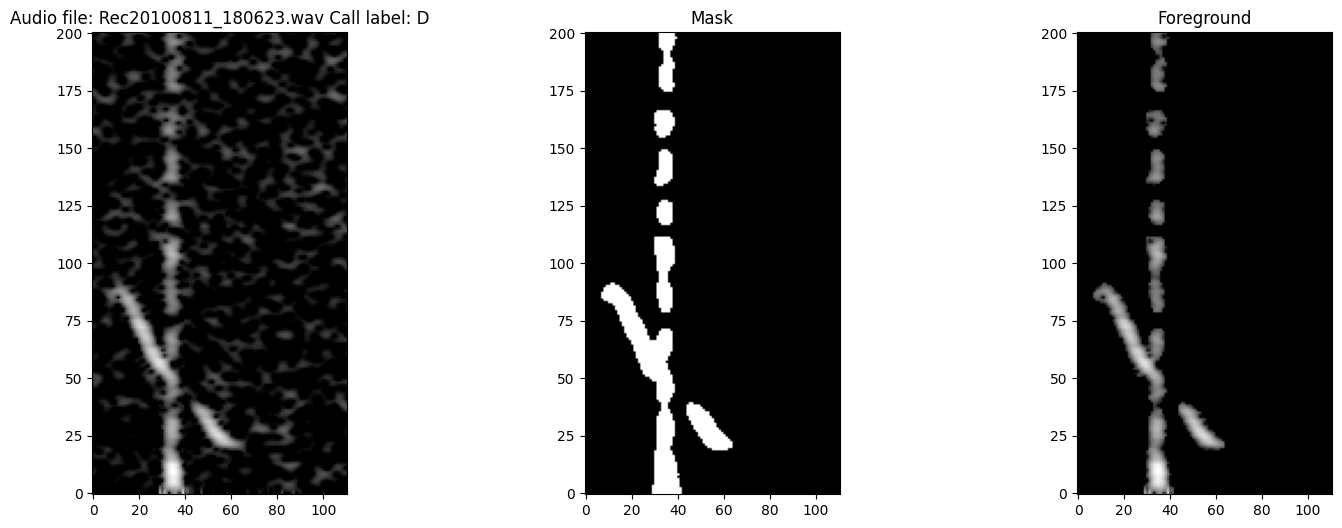

In [19]:
# plot spectrograms from each deployment
# CalCOFI-2004-07
for index, row in CC_2004_07.iterrows():

    audio_file_name = os.path.split(row['audio_file'])[1]
    audio = opensoundscape.Audio.from_file(row['audio_file'], sample_rate=48000, offset=row['start_time'], duration=6)

    if audio.samples.shape[0] > 0:  # Assuming audio.samples returns a numpy array of audio samples
        # create spectrogram:
        spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
                                                     overlap_samples=21600, fft_size=48000, 
                                                     scaling='density')
        
        # convert spectrogram to image:
        spec_image = spec.bandpass(0, 200).to_image()

        """
        # TO APPLY rlly_simple_back_sub

        # storing image as 2 dim array
        spec_image_arr = np.array(spec_image).astype(float)

        # collecting portion of image containing only noise
        background_noise_model = np.mean(spec_image_arr[:, :100], axis=1)

        # Subtract the background noise model from each column of the spectrogram
        spec_image_arr_mod2 = spec_image_arr.copy()
        for i in range(spec_image_arr.shape[1]):
            spec_image_arr_mod2[:, i] -= background_noise_model

        # apply threshold to filter out parts of the background ( difference between background and foreground image)
        spec_image_arr_mod3 = spec_image_arr_mod2.copy()
        spec_image_arr_mod3[spec_image_arr_mod3 < 0 ] = 0 

        h = 201
        w = 111
        np.reshape(spec_image_arr_mod3,(h,w))
        gray_spec = np.asarray(spec_image_arr_mod3)
        gray_spec = np.uint8(gray_spec)
        """
        
        
        gray_spec = np.asarray(spec_image) #comment out if applying rlly_simple_back_sub simultaneously

        # Apply GaussianBlur to smooth the image and reduce noise
        #blurred_spec = cv2.GaussianBlur(gray_spec, (25,25), 0)
        #blurred_spec = cv2.medianBlur(gray_spec, 25)
        blurred_spec = cv2.bilateralFilter(gray_spec, 9, 75, 75) #applies extra Gaussian filter for keeping edges sharp
            # Gaussian function of intensity difference makes sure that only those pixels with similar intensities to the central pixel are considered for blurring
            # Preserves edges since pixels at edges have large intensity variation

        # Use adaptive thresholding to separate the foreground from the background
        # OTSU algorithm automatically finds optimal global threshold value
        _, thresh = cv2.threshold(blurred_spec, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours of the thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty mask to store the foreground
        mask = np.zeros_like(gray_spec)

        # Draw the contours on the mask
        cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED) # FILLED fills in space connected by contours

        # Perform bitwise_and to get the foreground
        foreground = cv2.bitwise_and(gray_spec, mask) # TRUE iff both pixels are greater than zero


        # Display the original spectrogram, foreground, and background-subtracted spectrogram
        plt.figure(figsize=(18, 6))

        plt.subplot(131)
        #plt.imshow(gray_spec, cmap='gray')
        plt.imshow(np.flipud(gray_spec), cmap='gray', origin='lower')
        #plt.title('Original Spectrogram')
        plt.title(f'Audio file: {audio_file_name} Call label: {row["annotation"]}')

        plt.subplot(132)
        #plt.imshow(foreground, cmap='gray')
        plt.imshow(np.flipud(mask), cmap='gray', origin='lower')
        plt.title('Mask')

        plt.subplot(133)
        #plt.imshow(background_subtracted_spec, cmap='gray')
        plt.imshow(np.flipud(foreground), cmap='gray', origin='lower')
        plt.title('Foreground')

        plt.show()

        




    #spec = opensoundscape.Spectrogram.from_audio(audio, window_type='hamming', window_samples=24000, 
                                                                #overlap_samples=21600, fft_size=48000, 
                                                                #decibel_limits=(-100, 100), scaling='density')
    else:
        print(f"No audio samples found for file: {row['audio_file']}")


/var/folders/2b/m36gp23n22gfsgzj3p3gv9km0000gp/T/ipykernel_85705/1212496415.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='spec.jpg' mode='r' encoding='UTF-8'>
  spec_image = spec_image = cv2.imread("spec.jpg")


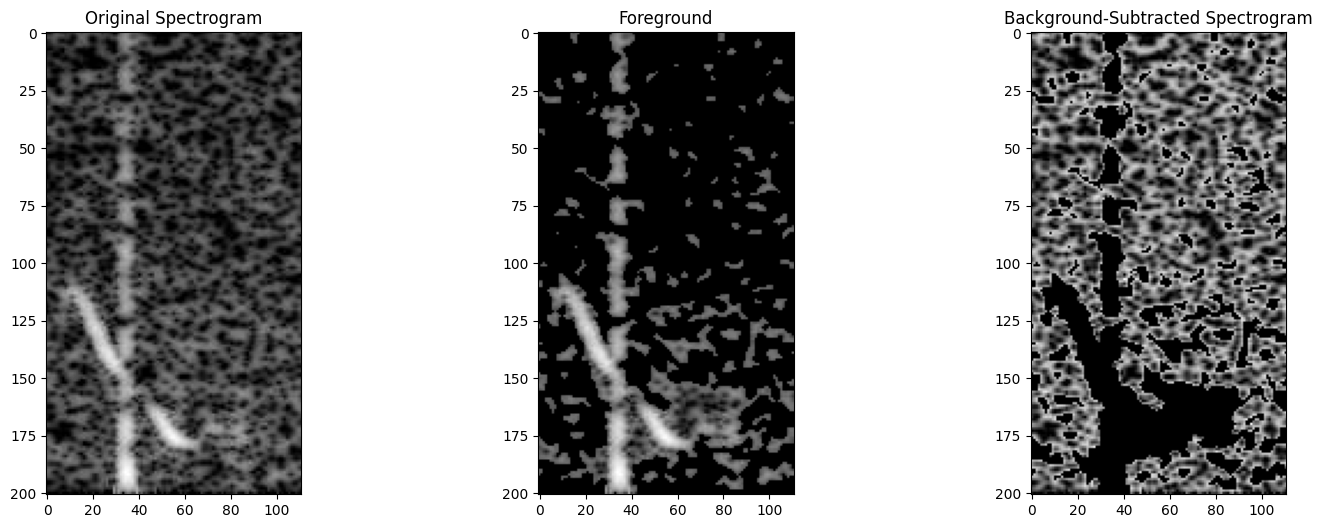

In [21]:
spec_image = spec_image = cv2.imread("spec.jpg")

gray_spec = cv2.cvtColor(spec_image, cv2.COLOR_RGB2GRAY)

# Apply GaussianBlur to smooth the image and reduce noise
blurred_spec = cv2.GaussianBlur(gray_spec, (5, 5), 0)

# Use adaptive thresholding to separate the foreground from the background
_, thresh = cv2.threshold(blurred_spec, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours of the thresholded image
contours, _ = cv2.findContours(1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask to store the foreground
mask = np.zeros_like(gray_spec)

# Draw the contours on the mask
cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

# Perform bitwise_and to get the foreground
foreground = cv2.bitwise_and(gray_spec, mask)

# Subtract the background from the original spectrogram
background_subtracted_spec = gray_spec - foreground

# Display the original spectrogram, foreground, and background-subtracted spectrogram
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(gray_spec, cmap='gray')
plt.title('Original Spectrogram')

plt.subplot(132)
plt.imshow(foreground, cmap='gray')
plt.title('Foreground')

plt.subplot(133)
plt.imshow(background_subtracted_spec, cmap='gray')
plt.title('Background-Subtracted Spectrogram')

plt.show()

In [ ]:
dio_file_name} Call label: {row["annotation"]} start time: {row["start_time"]} end time: {row["end_time"]}')
    plt.axis('on')